This script analyzes optostim neuropixel data and looks for significant responses during stimulation compared to baseline.

1. Loads relevant data
    - Preprocessed data from server
    - ECoG latency by stim site
2. Calculates significant responses
    - two-tailed t-test between FR during stim vs. before
3. Plots PSTH and rasters for significantly modulated units
4. Finds and plots waveforms of responsive units
5. Plots the LFP response.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aopy
import os
import pandas as pd
from db import dbfunctions as db
from ipywidgets import interactive, widgets
import scipy
import h5py
from tqdm.auto import tqdm 
import seaborn as sn
import sklearn
from sklearn.decomposition import PCA, FactorAnalysis
from itertools import compress
import multiprocessing as mp
import time
import math
from scipy.fft import fft
import glob
from datetime import date

In [2]:
# General data parameters
subject = 'affi'
task_coords = 'yzx'
task_perturb = None
task_rotation = 0

# Paths
ecog_signal_path = "/home/aolab/gdrive/Lab equipment/electrophysiology/210910_ecog_signal_path.xlsx"
elec_to_pos = "/home/aolab/gdrive/Lab equipment/electrophysiology/our signal path definitions/244ch_viventi_ecog_elec_to_pos.xlsx"
data_path_preproc = '/media/moor-data/preprocessed.new/'
data_path_raw = '/media/moor-data/raw/'
base_save_dir = "/media/moor-data/results/Ryan/neuropixel_targeting/"
ecog_dec_acc_file_name = 'ecog_decoding_maps/npinsert_ecog_decoding_all'
# save_dir = "/home/aolab/gdrive/People/RyanCanfield/Results/beignet_analysis/optostim_population_dynamics"

np_inserts = ['NPinsert72', 'NPinsert137']
ninserts = len(np_inserts)
np_ecog_mapping_path = [f"/home/aolab/gdrive/Lab equipment/electrophysiology/Neuropixels/channel_mapping/{insert}_ecog_mapping_{subject}.xlsx" for insert in np_inserts]


# Neuropixel data parame/ters
implant_name = ['NP_Insert72', 'NP_Insert137']
start_date = '2023-07-13'
end_date = date.today()
elec_config = 'bottom'
spike_bin_width_mc = 0.005 #[s]

# Alignment parameters
tbefore = 0.25
tafter = 0.25
min_trial_prop = 0.1
min_fr = 0.1

# Visualization parameters
colors = sn.color_palette(n_colors=9)

In [3]:
def calc_autocorr_func(data, lags=None):
    '''
    Args:
        data (ntime, ...):
        lags (nlag): Indicies of lags to analyze. If None, compute autocorrelation at each possible lag.
    '''
    
    ntime = data.shape[0]
    if lags is None:
        lags = np.arange(-ntime+1, ntime-1)
    nlags = len(lags)
    
    autocorr_func = np.zeros(nlags)*np.nan
    for ilag, lag in enumerate(lags):
        # print(data.shape, np.roll(data,lag,axis=0).shape)
        # autocorr_func.append(np.apply_along_axis(np.correlate, 0, data, np.roll(data,lag,axis=0)))
        # print(data.shape, np.roll(data,lag,axis=0).shape)
        autocorr_func[ilag] = np.correlate(data, np.roll(data,lag,axis=0))
    return autocorr_func, lags

def load_parsed_ksdata(kilosort_dir, data_dir):
    '''
    load kilosort data (spike indices, clusters, and label) parsed into the task entries
    This data is not still synchronized
    
    Args:
        kilosort_dir (str): kilosort directory (ex. '/data/preprocessed/kilosort')
        data_dir (str): data directory that contains parsed data (ex. '2023-06-30_Neuropixel_ks_affi_bottom_port1_9847')
        
    Returns:
        spike_indices (nspikes): spike indices detected by kilosort (not spike times)
        spike_clusters (nspikes): unit label detected  by kilsort
    '''
    
    # Path for loading spikes and clusters
    data_path = os.path.join(kilosort_dir, data_dir)
    spike_path = os.path.join(data_path,'spike_indices_entry.npy')
    cluster_path = os.path.join(data_path,'spike_clusters_entry.npy')
    label_path = os.path.join(data_path,'ks_label.npy')

    # Load spikes and clusters
    spike_indices = np.load(spike_path)
    spike_clusters = np.load(cluster_path)
    ks_label = np.load(label_path)
    
    return spike_indices, spike_clusters, ks_label

def classify_ks_unit(spike_times, spike_label):
    '''
    Classify unit activity identified by kilosort into each single unit
    
    Args:
        spike_times (nspikes): spike times generated by kilosort
        spike_label (nspikes): cluster labels of each spike generated by kilosort
        
    Returns:
        spike_times_unit (dict): spike times for each unit
    '''
    
    spike_times_unit = {}
    
    for unit_label in np.unique(spike_label):
        spike_times_unit[f'{unit_label}'] = spike_times[spike_label==unit_label.astype(int)]
    
    return spike_times_unit

def calc_ks_waveforms(raw_data, sample_rate, spike_times_unit, templates, channel_pos, waveforms_nch=10, time_before=1000., time_after=1000.):
    '''
    Calculate waveforms, waveform channels, and positions of units, using templates from kilosort
    
    args:
        raw_data (nt,nch): time series neural data to detect spikes and extract waveforms from.
        sample_rate (float): sampling rate (Hz)
        spike_times_unit (dict): spike times for each unit identified by kilosort
        templates (n_unit, n_points, nch): templates that kilosort used to detect spikes
        channel_pos (nch, 2): channel positions
        waveforms_nch (int, optional): the number of channels with large amplitude of templates
        time_before (float, optional): time [us] to include before the start of each trial
        time_after (float, optional): time [us] to include after the start of each trial
    
    returns
        tuple: tuple containing:
            | **unit_waveforms (dict):** waveforms for each unit. The shape is (nspikes,  m_points, waveforms_nch)
            | **unit_waveforms_ch (n_unit, waveforms_nch):** large amplitude channels in templates
            | **unit_pos (dict):** channel positions of each unit
    '''
    
    time_before *= 1e-6
    time_after *= 1e-6
    nch = channel_pos.shape[0]
    duration = int((time_before + time_after)*sample_rate)
    
    unit_waveforms_ch = {}
    unit_waveforms = {}
    unit_pos = {}

    for iunit, unit in enumerate(spike_times_unit.keys()):
        # Look at high amplitude channels in templates
        amp_template_ch = np.zeros(nch)
        for ich in range(nch):
            amp_template_ch[ich] = np.max(templates[int(unit),:,ich])-np.min(templates[int(unit),:,ich]) # don't use iunit instead of int(unit)

        # Sort high amplitude channels and save channels and their positions
        large_amp_ch = np.argsort(amp_template_ch)[::-1][:waveforms_nch]
        unit_waveforms_ch[f'{unit}'] = large_amp_ch
        unit_pos[f'{unit}'] = channel_pos[large_amp_ch[0],:]

        # Get waveforms in high amplitude channels for each spike
        unit_times = spike_times_unit[f'{unit}']
        waveforms = np.zeros((unit_times.shape[0],duration,waveforms_nch))*np.nan
        for ispike, unit_time in enumerate(unit_times):
            start = int((unit_time - time_before)*sample_rate)
            end = start + duration

            if np.logical_and(end < raw_data.shape[0], start >= 0): # Ensure there are enough data points to grab the waveform
                for ich, ch in enumerate(large_amp_ch):
                    waveforms[ispike,:,ich] = raw_data[start:end,ch]
                    
        unit_waveforms[f'{unit}'] = waveforms
    
    return unit_waveforms, unit_waveforms_ch, unit_pos

# Load Data

In [4]:
# Load neuropixel insert location mapping data
ecog_dec_acc = aopy.data.base.load_hdf_group(base_save_dir, ecog_dec_acc_file_name)

In [5]:
# Load neuropixel center-out task data
subject = 'affi'
bad_tes = [10798, 17300]
opto_entries =  db.get_task_entries(subject__name=subject, task__name='laser only', date=(start_date, end_date))
opto_entries = [oe for oe in opto_entries if 'neuropixel_port1_drive_type' in oe.task_params and oe.task_params['neuropixel_port1_drive_type'] in implant_name
                and oe.entry_name != 'flash']
opto_entries = [oe for oe in opto_entries if oe.id not in bad_tes]

print(opto_entries)
print(len(opto_entries))

[2024-05-08 10:40:22.151976: affi on laser only task, id=17306, 2024-05-08 10:45:04.477024: affi on laser only task, id=17307, 2024-05-08 11:00:58.763380: affi on laser only task, id=17308, 2024-05-08 11:05:56.192770: affi on laser only task, id=17309, 2024-05-08 11:20:33.414320: affi on laser only task, id=17310, 2024-05-08 11:25:16.120424: affi on laser only task, id=17311]
6


## Load spiking data

In [6]:
subjects = [subject for oe in opto_entries]
te_ids = [oe.id for oe in opto_entries]
oe_dates = [oe.date.date() for oe in opto_entries]
df = aopy.data.bmi3d.tabulate_stim_data(data_path_preproc, subjects, te_ids, oe_dates,metadata=['stimulation_site','neuropixel_port1_drive_type'],  debug=False)

  0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
trial_time_axis = np.arange(-tbefore, tafter, spike_bin_width_mc)
time_axis = np.linspace(-tbefore, tafter, int((tafter+tbefore)/spike_bin_width_mc))
ntime = len(time_axis)

In [8]:
start = time.time()
spike_times = []
unit_labels = []
laser_times = []
laser_widths = []
spike_segs = []
spike_align = []
spike_labels = []
recording_site = []
np_drive_name = []
stim_site = []
good_opto_entries = []
autocorr_func = []
for ioe, oe in enumerate(tqdm(opto_entries[:])):

    ########################################################
    ### Load spike times across days
    ######################################################## 
    # Load data
    exp_data, exp_metadata = aopy.data.load_preproc_exp_data(data_path_preproc, subject, oe.id, oe.date.date())
    filename_opto = aopy.data.get_preprocessed_filename(subject, oe.id, oe.date.date(), 'ap')
    try:
        # print('loading_data')
        ap_data = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_opto, 'ap')
        ap_metadata = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_opto, 'metadata')
        laser_info = aopy.preproc.bmi3d.get_laser_trial_times(data_path_preproc, subject, oe.id, oe.date.date())
        # print('done')
    except:
        continue

    ########################################################
    unit_labels.append(ap_data['unique_label'])
    spike_times.append(ap_data['unit']) # Assumes spike labels are consistent across recording sessions (works if recorded on the same day, but otherwise it does not)
    laser_times.append(laser_info[0])
    laser_widths.append(laser_info[1])
    stim_site.append(int(exp_metadata['stimulation_site']))
    recording_site.append(int(exp_metadata['neuropixel_port1_site']))
    np_drive_name.append(exp_metadata['neuropixel_port1_drive_type'])
    ########################################################
    
    spike_segs_day = {}
    spike_align_day = np.zeros((ntime, len(laser_info[0]), len(ap_data['unique_label'])))*np.nan # (ntime, ntrials, nunits)
    autocorr_func_day = []
    for iunit, unitid in enumerate(ap_data['unique_label']):
        binned_spikes, time_bins = aopy.precondition.bin_spike_times(ap_data['unit'][str(unitid)], 0, laser_info[0][-1]+10, spike_bin_width_mc)
        # autocorr_func_day.append(calc_autocorr_func(ap_data['unit'][str(unitid)], lags=None)[0])
        
        # Trial align 
        spike_align_day[:,:,iunit] = aopy.preproc.trial_align_data(binned_spikes, laser_info[0], tbefore, tafter, 1/spike_bin_width_mc)[:,0,:]


    spike_segs.append(spike_segs_day)
    spike_align.append(spike_align_day)
    good_opto_entries.append(oe)
    # autocorr_func.append(autocorr_func_day)
    # print(100*ioe/len(opto_entries), '%')

  0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
implants = ['NPinsert72' if np_drive_name[irec] == 'NP_Insert72' else 'NPinsert137' for irec in range(len(np_drive_name))] #Rename because name in bmi3d is slightly different (TODO)

In [10]:
# Identify which units are stable by being active on a high proportion of trials and above a low minimum FR
stable_unit_lbl = []
stable_unit_mask = []
stable_unit_idx = []
target_idx_good = []
target_idx_ordered_mask = []
# Get stable unit idx and labels
for ie, entry in enumerate(good_opto_entries):
    min_trials = len(laser_times[ie])*min_trial_prop
    stable_unit_lbl.append(unit_labels[ie][np.where(np.logical_and(np.sum(np.max(spike_align[ie]>0, axis=0), axis=0)>min_trials, np.mean(spike_align[ie], axis=(0,1))>min_fr))[0]])
    stable_unit_mask.append(np.logical_and(np.sum(np.max(spike_align[ie]>0, axis=0), axis=0)>min_trials, np.mean(spike_align[ie], axis=(0,1))>min_fr))
    stable_unit_idx.append(np.where(stable_unit_mask[ie])[0])
nstable_unit_idx = [len(stable_unit_idx[id]) for id in range(len(good_opto_entries))]

## Calculate spikeresponse significance

In [11]:
offset = 2#[idx]
# Calculate significance of response
laser_start_idx = [(np.zeros(len(laser_times[ioe]))+np.where(trial_time_axis>=0)[0][0]).astype(int)+offset for ioe in range(len(good_opto_entries))]
laser_stop_idx = [laser_start_idx[ioe]+np.round(laser_widths[ioe]/spike_bin_width_mc).astype(int)-(2*offset+1) for ioe in range(len(good_opto_entries))]
baseline_start_idx = [(np.zeros(len(laser_times[ioe]))+np.where(trial_time_axis>=0)[0][0]).astype(int)-(laser_stop_idx[ioe]-laser_start_idx[ioe])-offset for ioe in range(len(good_opto_entries))]
baseline_stop_idx = [(np.zeros(len(laser_times[ioe]))+np.where(trial_time_axis>=0)[0][0]).astype(int)-offset for ioe in range(len(good_opto_entries))]

unit_resp_sig = []
for ioe in tqdm(range(len(good_opto_entries))):
    temp_unit_sig = np.zeros(nstable_unit_idx[ioe])*np.nan
    for iunit, unit_lbl in enumerate(stable_unit_idx[ioe]):
        null_points = []
        alt_points = []
        [null_points.extend(spike_align[ioe][baseline_start_idx[ioe][itrial]:baseline_stop_idx[ioe][itrial],itrial,unit_lbl]) for itrial in range(len(laser_times[ioe]))]
        [alt_points.extend(spike_align[ioe][laser_start_idx[ioe][itrial]:laser_stop_idx[ioe][itrial],itrial,unit_lbl]) for itrial in range(len(laser_times[ioe]))]
        _, temp_unit_sig[iunit] = scipy.stats.ttest_ind(np.array(null_points), np.array(alt_points), nan_policy='omit')
    
    unit_resp_sig.append(temp_unit_sig)

  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
# Control for multiple comparisons using false discovery rate
from statsmodels.stats.multitest import fdrcorrection
resp_unit_idx = [stable_unit_idx[ioe][fdrcorrection(unit_resp_sig[ioe])[0]] for ioe in range(len(good_opto_entries))]
nresp_unit = [len(resp_unit_idx[ioe]) for ioe in range(len(good_opto_entries))]

## Load LFP

In [13]:
aligned_lfp_data = []
aligned_lfp_data_trial = []
noptotrials = []
bad_ch_cutoff = []
offset_lfp = 20
baseline_start_idx_lfp = 0
clean_lfp_path = f"/media/moor-data/postprocessed/{subject}/neuropixel_lfp_destriped"
aopy.utils.release_memory_limit()
for ioe, oe in enumerate(tqdm(opto_entries[:])):

    ########################################################
    ### Load spike times across days
    ########################################################
    session_number = 0
 
    # Load data
    exp_data, exp_metadata = aopy.data.load_preproc_exp_data(data_path_preproc, subject, oe.id, oe.date.date())
    filename_opto = aopy.data.get_preprocessed_filename(subject, oe.id, oe.date.date(), 'lfp')
    try:
        lfp_data = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_opto, 'lfp')
        clean_lfp_data, bad_ch = aopy.data.base.pkl_read(f'lfp_destriped_{oe.id}', clean_lfp_path)
        lfp_metadata = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_opto, 'metadata')
        laser_info = aopy.preproc.bmi3d.get_laser_trial_times(data_path_preproc, subject, oe.id, oe.date.date())
    except:
        print(f'Could not load {ioe}: {oe.id}')
        continue
    clean_lfp_data = clean_lfp_data.T
    clean_lfp_data[:,np.where(bad_ch[0]==3)[0]] = np.nan
    if len(np.where(bad_ch[0]==3)[0]) > 0:
        bad_ch_cutoff.append(np.where(bad_ch[0]==3)[0][0]-25)
    else:
        bad_ch_cutoff.append(nch-1)
    print(bad_ch_cutoff)
    samplerate_lfp = lfp_metadata['sample_rate']
    ntime_lfp, nch = clean_lfp_data.shape
    noptotrials_temp = len(laser_info[0])
    trial_time_axis_lfp = np.arange(-tbefore, tafter, 1/samplerate_lfp)
    baseline_stop_idx_lfp = np.where(trial_time_axis_lfp>=0)[0][0]-offset_lfp
    
    # Nan channels outside the brain
    
    talign_times_opto_lfp, talign_idx_opto_lfp = aopy.preproc.base.trial_align_times(lfp_data['sync_timestamp'], laser_info[0], 
                                                              tbefore, tafter)
    ntrial_time = np.min([len(idx) for idx in talign_idx_opto_lfp])
    
    # Trial align 
    lfp_align_day = np.zeros((ntrial_time, noptotrials_temp, nch))
    for itrial, trial_idx in enumerate(talign_idx_opto_lfp):
        lfp_align_day[:,itrial,:] = clean_lfp_data[trial_idx[:ntrial_time],:]*lfp_metadata['bit_volts']
        
    
    temp_lfp = np.mean(lfp_align_day, axis=1)
    aligned_lfp_data.append(temp_lfp - np.mean(temp_lfp[baseline_start_idx_lfp:baseline_stop_idx_lfp,:], axis=0))
    aligned_lfp_data_trial.append(lfp_align_day)
    noptotrials.append(noptotrials_temp)
    
trial_time_axis_lfp = np.arange(-tbefore, tafter, 1/samplerate_lfp)
laser_start_idx_lfp = [(np.zeros(len(laser_times[ioe]))+np.where(trial_time_axis_lfp>=0)[0][0]).astype(int)+offset_lfp for ioe in range(len(good_opto_entries))]
laser_stop_idx_lfp = [laser_start_idx_lfp[ioe]+np.round(laser_widths[ioe]*samplerate_lfp).astype(int)-(2*offset_lfp+1) for ioe in range(len(good_opto_entries))]

  0%|          | 0/6 [00:00<?, ?it/s]

[112]
[112, 383]
[112, 383, 104]
[112, 383, 104, 383]
[112, 383, 104, 383, 178]
[112, 383, 104, 383, 178, 383]


In [14]:
offset_lfp = 20
laser_start_idx_lfp = [(np.zeros(len(laser_times[ioe]))+np.where(trial_time_axis_lfp>=0)[0][0]).astype(int)+offset_lfp for ioe in range(len(good_opto_entries))]
laser_stop_idx_lfp = [laser_start_idx_lfp[ioe]+np.round(laser_widths[ioe]*samplerate_lfp).astype(int)-(2*offset_lfp+1) for ioe in range(len(good_opto_entries))]

## Distance between recording site and stim site

In [15]:
if subject == 'beignet':
    for irec in range(len(recording_site)):
        if irec > 14:
            implants[irec] = "NPinsert137"

    recording_site[8] = 18
    recording_site[10] = 47
    recording_site[18] = 71
    recording_site[38] = 45
    stim_site[18] = 72
    stim_site[38] = 46

In [16]:
np_ecog_mapping = {}
for iinsert, insert in enumerate(np_inserts):
    np_ecog_mapping[insert] = pd.read_excel(np_ecog_mapping_path[iinsert])
    
rec_pos = np.array([np.array((np_ecog_mapping[implants[irec]][f"{implants[irec]}_x"][rec_site-1], np_ecog_mapping[implants[irec]][f"{implants[irec]}_y"][rec_site-1])) for irec, rec_site in enumerate(recording_site)])
stim_pos = np.array([np.array((np_ecog_mapping[implants[istim]][f"{implants[istim]}_x"][int(stim_site)-1], np_ecog_mapping[implants[istim]][f"{implants[istim]}_y"][int(stim_site)-1])) for istim, stim_site in enumerate(stim_site)])
rec_stim_dist = np.sqrt(np.abs(rec_pos[:,0]-stim_pos[:,0])**2 + np.abs(rec_pos[:,1]-stim_pos[:,1])**2)

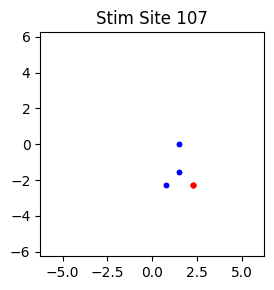

In [17]:
unique_stim_sites = np.unique(stim_site)
fig, ax = plt.subplots(1,len(unique_stim_sites), figsize=(len(unique_stim_sites)*3,3))
for istim_site, unique_stim in enumerate(unique_stim_sites):
    if len(unique_stim_sites) > 1:
        ax[istim_site].plot(rec_pos[stim_site==unique_stim,0], rec_pos[stim_site==unique_stim,1], 'b.')
        ax[istim_site].plot(stim_pos[stim_site==unique_stim,0], stim_pos[stim_site==unique_stim,1], 'r.')
        ax[istim_site].set(xlim=(-6.25, 6.25), ylim=(-6.25, 6.25), title=f"Stim Site {unique_stim}")
        ax[istim_site].set_aspect('equal')
    else:
        ax.plot(rec_pos[stim_site==unique_stim,0], rec_pos[stim_site==unique_stim,1], 'b.')
        ax.plot(stim_pos[stim_site==unique_stim,0], stim_pos[stim_site==unique_stim,1], 'r.')
        ax.set(xlim=(-6.25, 6.25), ylim=(-6.25, 6.25), title=f"Stim Site {unique_stim}")
        ax.set_aspect('equal')
fig.tight_layout()
plt.show()

# Plot spike results

## PSTH

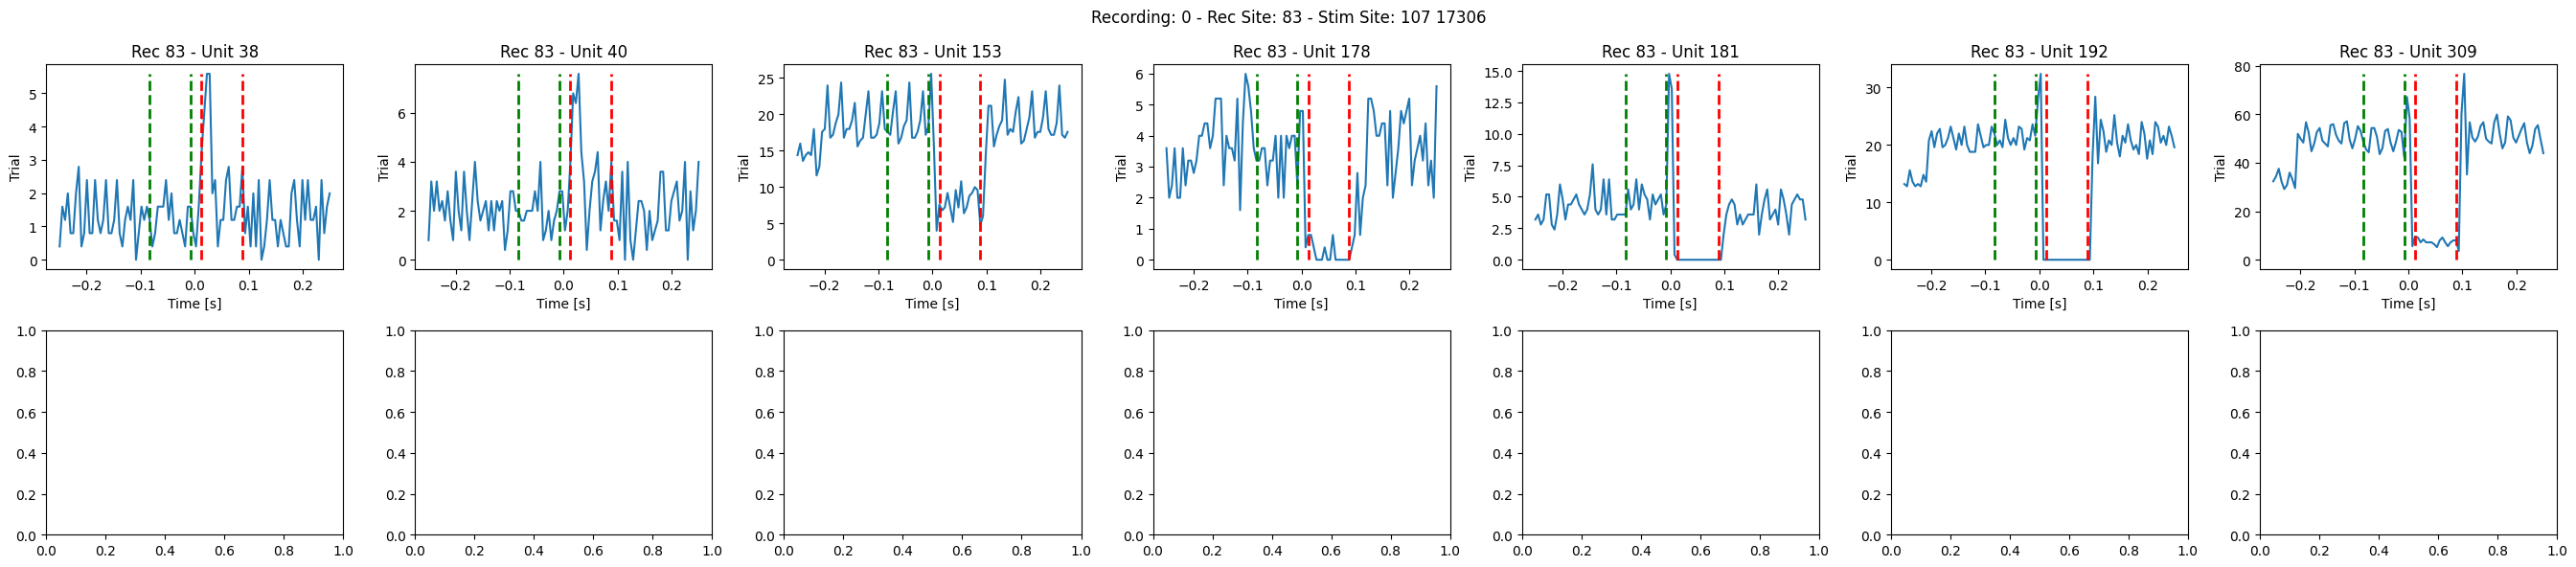

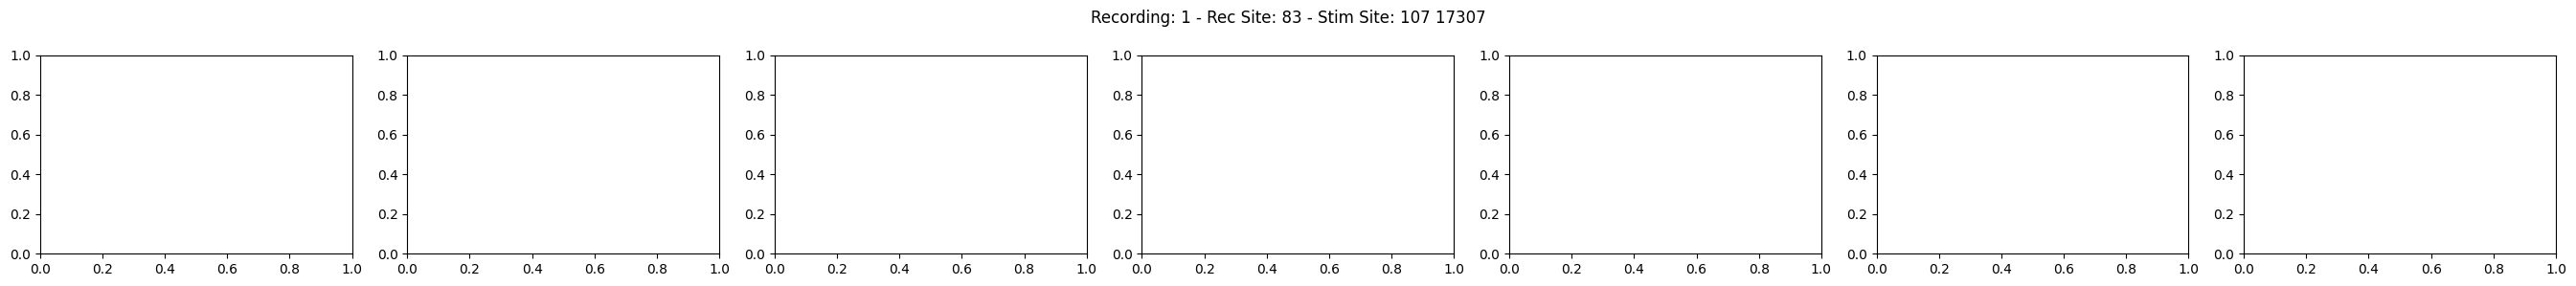

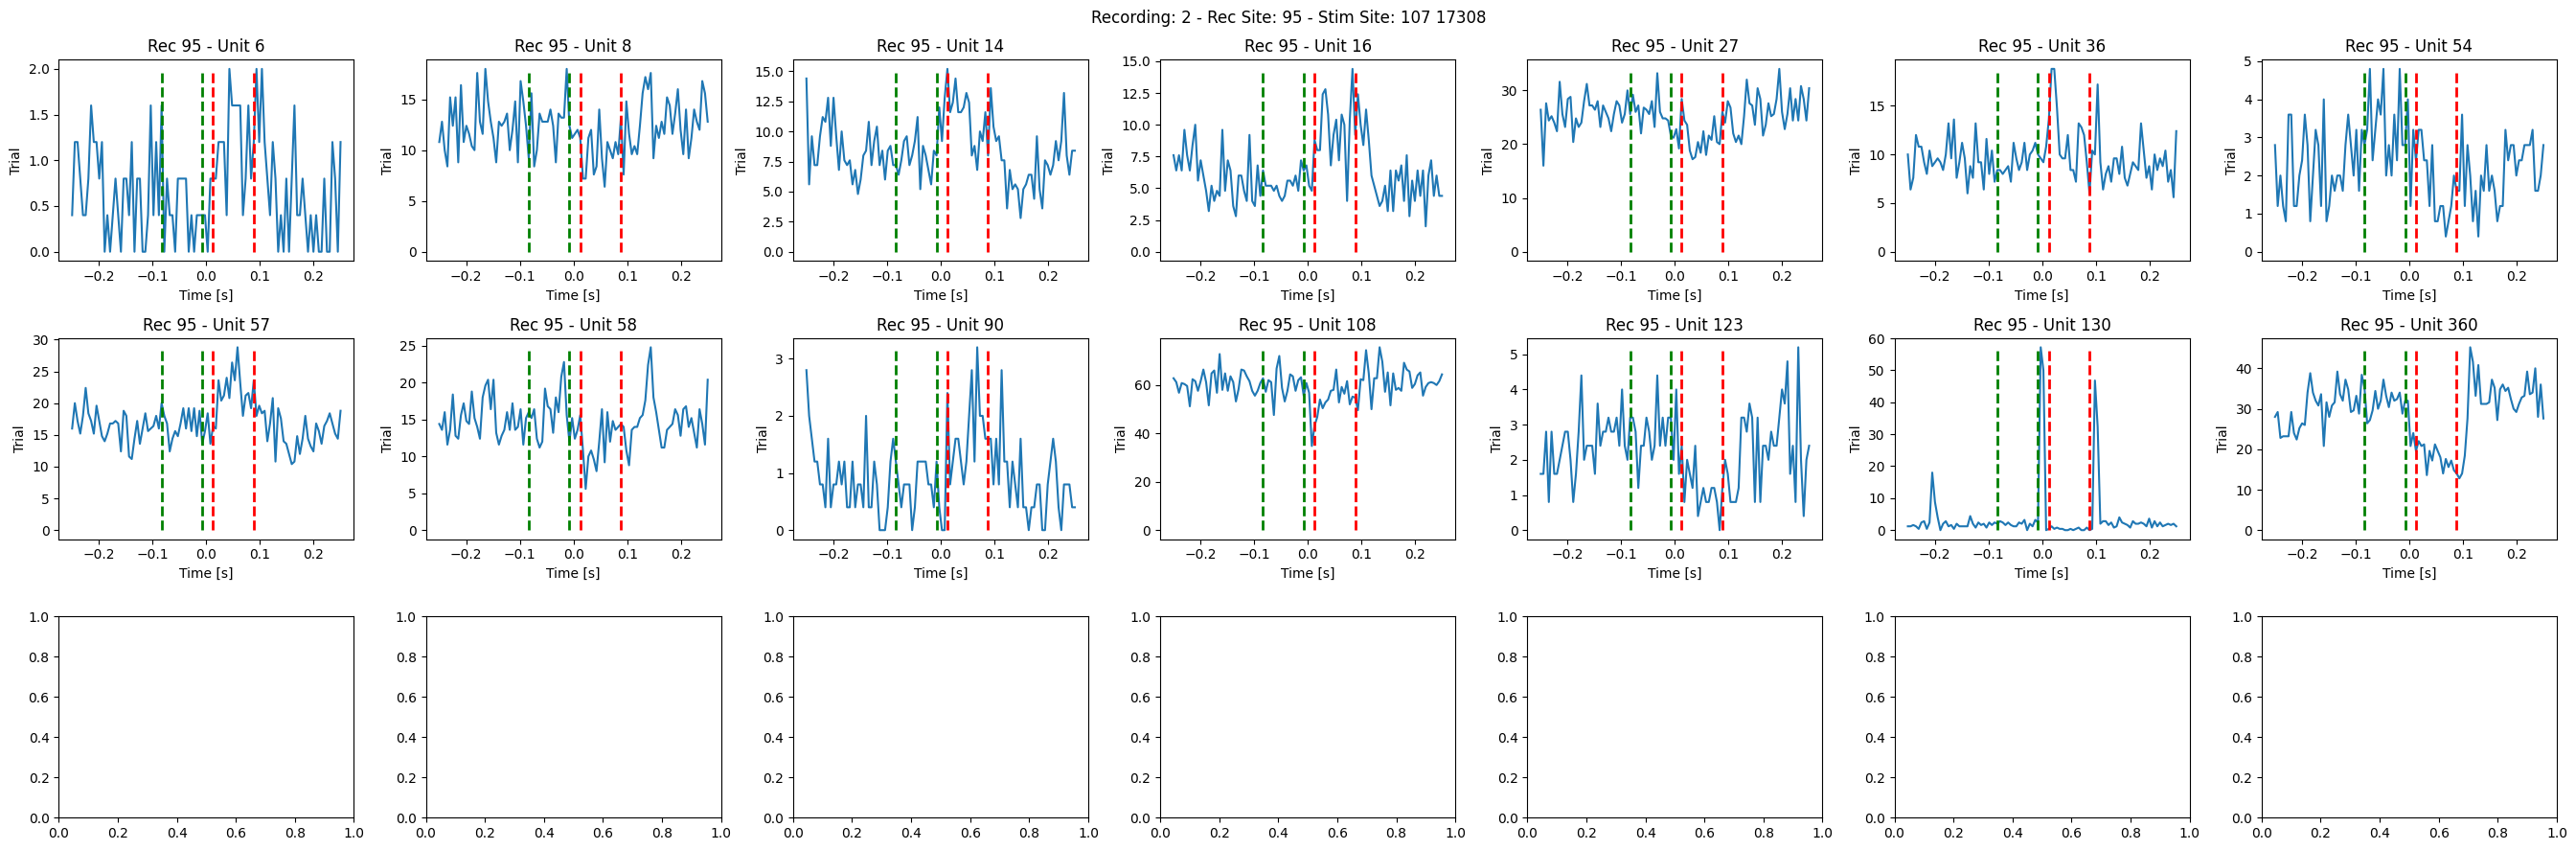

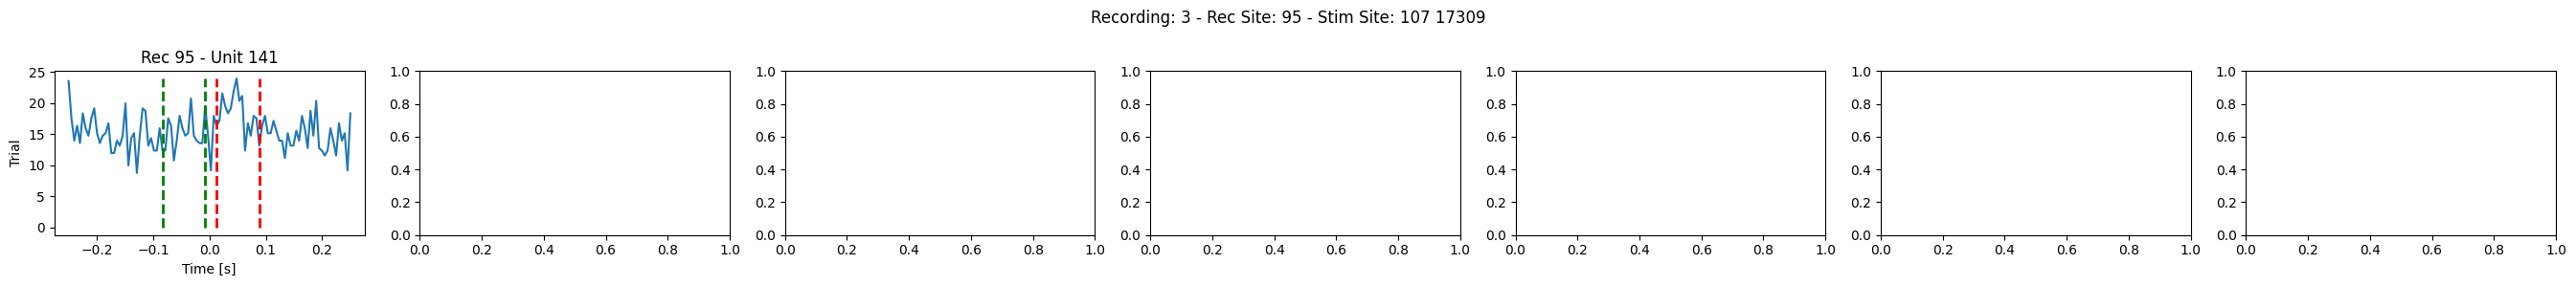

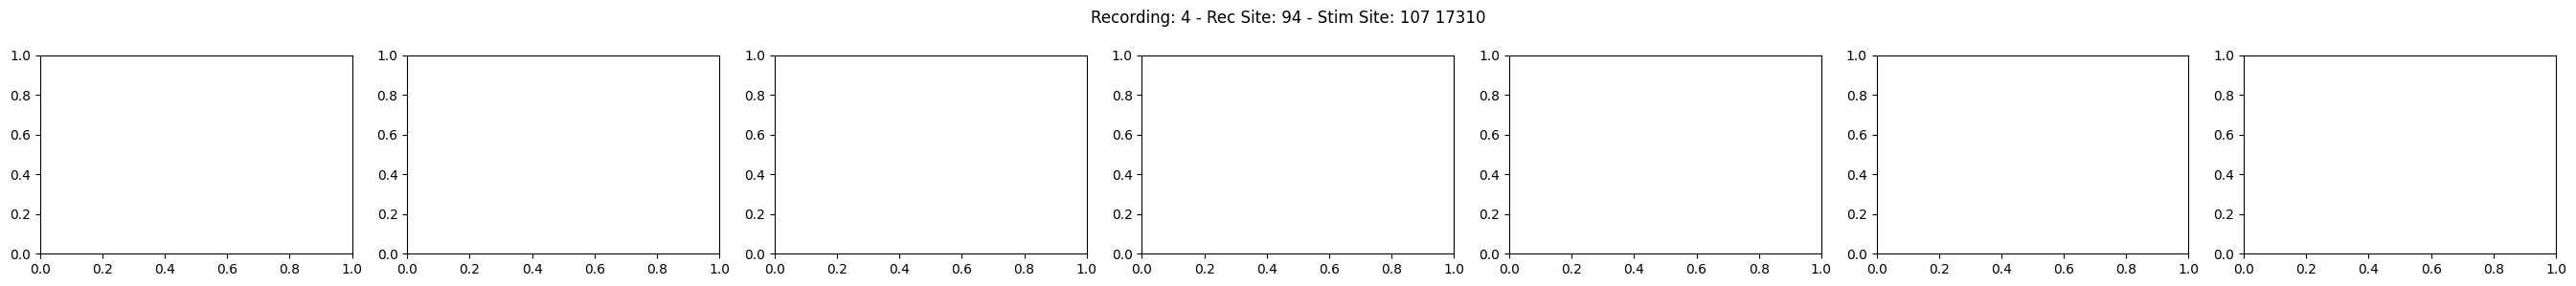

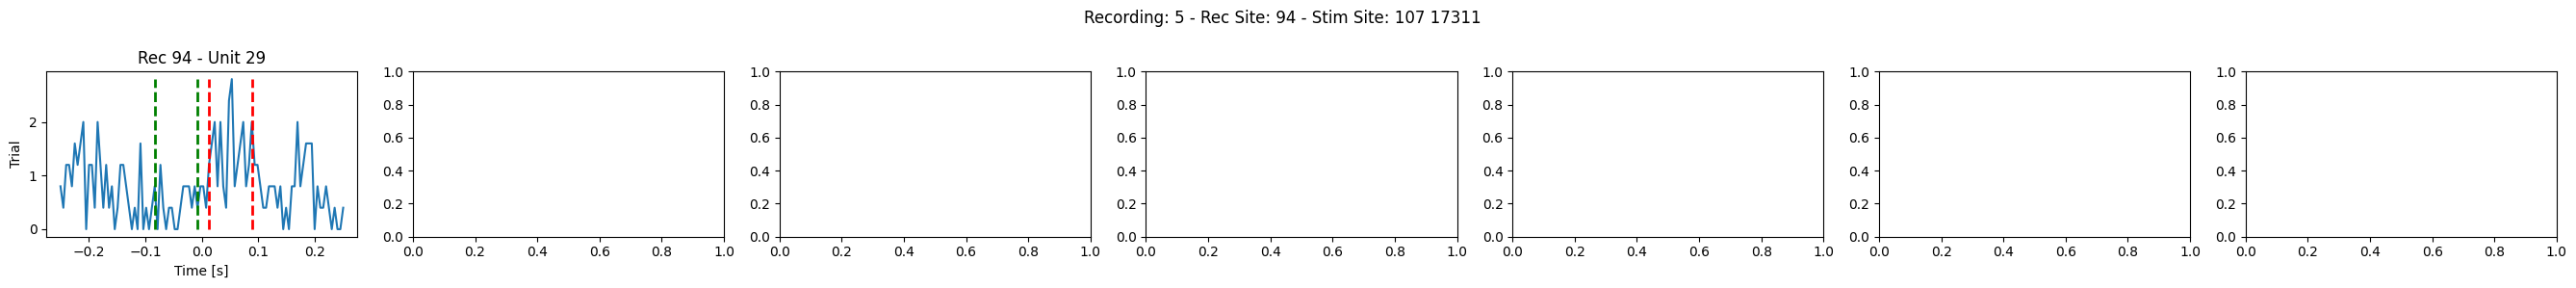

In [18]:
for ioe in range(len(good_opto_entries)):
    ncol = 7
    nrow = (len(resp_unit_idx[ioe])//ncol)+1
    fig, ax = plt.subplots(nrow, ncol, figsize=(27, nrow*3))
    for iplot, iunit in enumerate(resp_unit_idx[ioe]):
        irow = iplot//ncol
        icol = iplot % ncol
        
        try:
            # unit2plot = np.where(unit_labels[idate]==[iunit])[0][0]
            ax[irow, icol].plot(time_axis, np.nanmean(spike_align[ioe][:,:,iunit], axis=1))
            ax[irow, icol].plot([time_axis[int(np.median(laser_start_idx[ioe]))], time_axis[int(np.median(laser_start_idx[ioe]))]], [0,np.max(np.mean(spike_align[ioe][:,:,iunit], axis=1))], 'r--', linewidth=2)
            ax[irow, icol].plot([time_axis[int(np.median(laser_stop_idx[ioe]))], time_axis[int(np.median(laser_stop_idx[ioe]))]], [0,np.max(np.mean(spike_align[ioe][:,:,iunit], axis=1))], 'r--', linewidth=2)
            ax[irow, icol].plot([time_axis[int(np.median(baseline_start_idx[ioe]))], time_axis[int(np.median(baseline_start_idx[ioe]))]], [0,np.max(np.mean(spike_align[ioe][:,:,iunit], axis=1))], 'g--', linewidth=2)
            ax[irow, icol].plot([time_axis[int(np.median(baseline_stop_idx[ioe]))], time_axis[int(np.median(baseline_stop_idx[ioe]))]], [0,np.max(np.mean(spike_align[ioe][:,:,iunit], axis=1))], 'g--', linewidth=2)
            # ax[irow, icol].plot([0,0], [0,np.max(np.mean(spike_align[ioe][:,:,iunit], axis=1))], 'r--', linewidth=2)
            # ax[irow, icol].plot([np.median(laser_widths[ioe]),np.median(laser_widths[ioe])], [0,np.max(np.mean(spike_align[ioe][:,:,iunit], axis=1))], 'r--', linewidth=2)
            ax[irow, icol].set(xlabel='Time [s]', ylabel='Trial', title=f'Rec {recording_site[ioe]} - Unit {iunit}')
        except:
            ax[icol].plot(time_axis, np.mean(spike_align[ioe][:,:,iunit], axis=1))
            ax[icol].plot([time_axis[int(np.median(laser_start_idx[ioe]))], time_axis[int(np.median(laser_start_idx[ioe]))]], [0,np.max(np.mean(spike_align[ioe][:,:,iunit], axis=1))], 'r--', linewidth=2)
            ax[icol].plot([time_axis[int(np.median(laser_stop_idx[ioe]))], time_axis[int(np.median(laser_stop_idx[ioe]))]], [0,np.max(np.mean(spike_align[ioe][:,:,iunit], axis=1))], 'r--', linewidth=2)
            ax[icol].plot([time_axis[int(np.median(baseline_start_idx[ioe]))], time_axis[int(np.median(baseline_start_idx[ioe]))]], [0,np.max(np.mean(spike_align[ioe][:,:,iunit], axis=1))], 'g--', linewidth=2)
            ax[icol].plot([time_axis[int(np.median(baseline_stop_idx[ioe]))], time_axis[int(np.median(baseline_stop_idx[ioe]))]], [0,np.max(np.mean(spike_align[ioe][:,:,iunit], axis=1))], 'g--', linewidth=2)
            # ax[icol].plot([0,0], [0,np.max(np.mean(spike_align[ioe][:,:,iunit], axis=1))], 'r--', linewidth=2)
            # ax[icol].plot([np.median(laser_widths[ioe]),np.median(laser_widths[ioe])], [0,np.max(np.mean(spike_align[ioe][:,:,iunit], axis=1))], 'r--', linewidth=2)
            ax[icol].set(xlabel='Time [s]', ylabel='Trial', title=f'Rec {recording_site[ioe]} - Unit {iunit}')
            
    plt.suptitle(f'Recording: {ioe} - Rec Site: {recording_site[ioe]} - Stim Site: {stim_site[ioe]} {good_opto_entries[ioe].id}')
    fig.tight_layout()
    plt.show()

## Raster

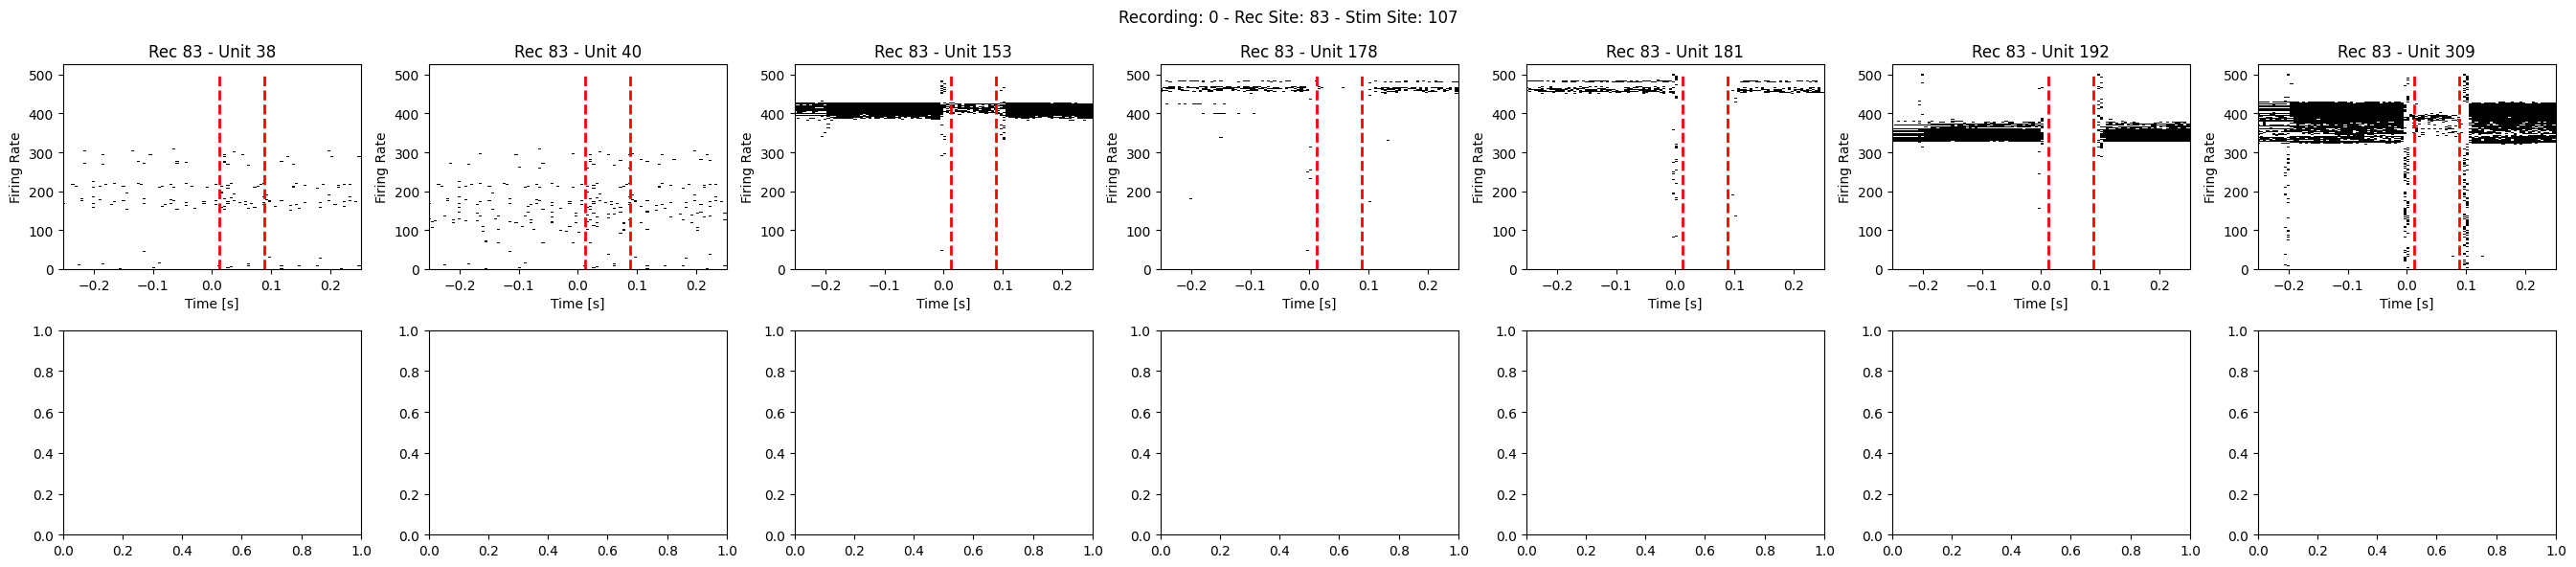

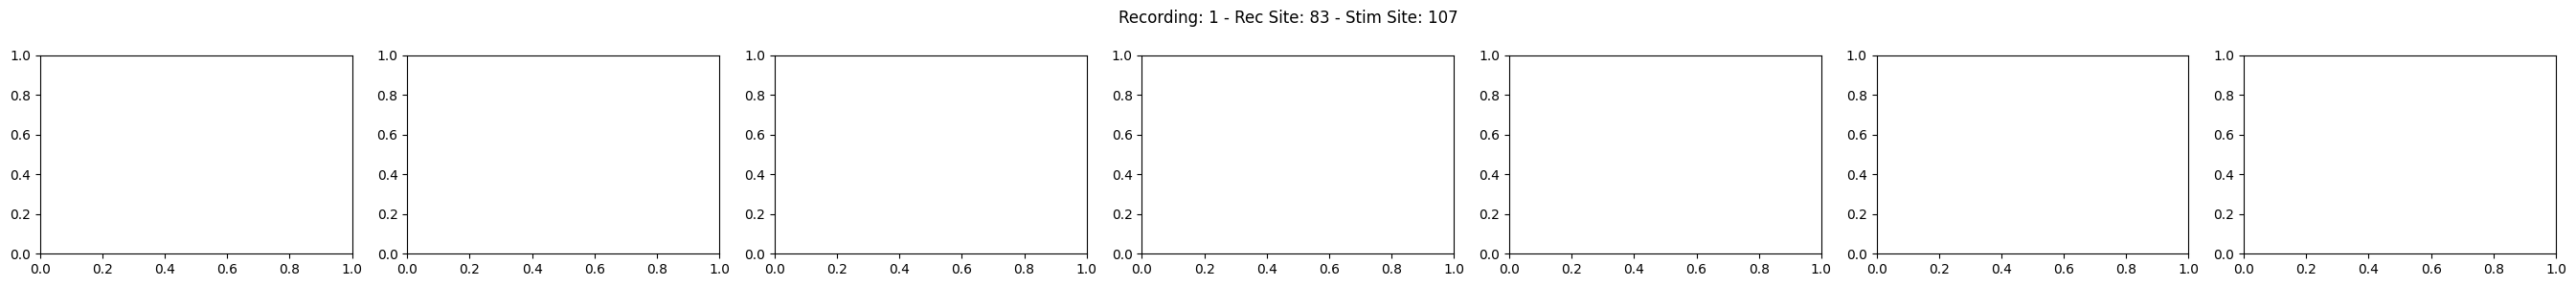

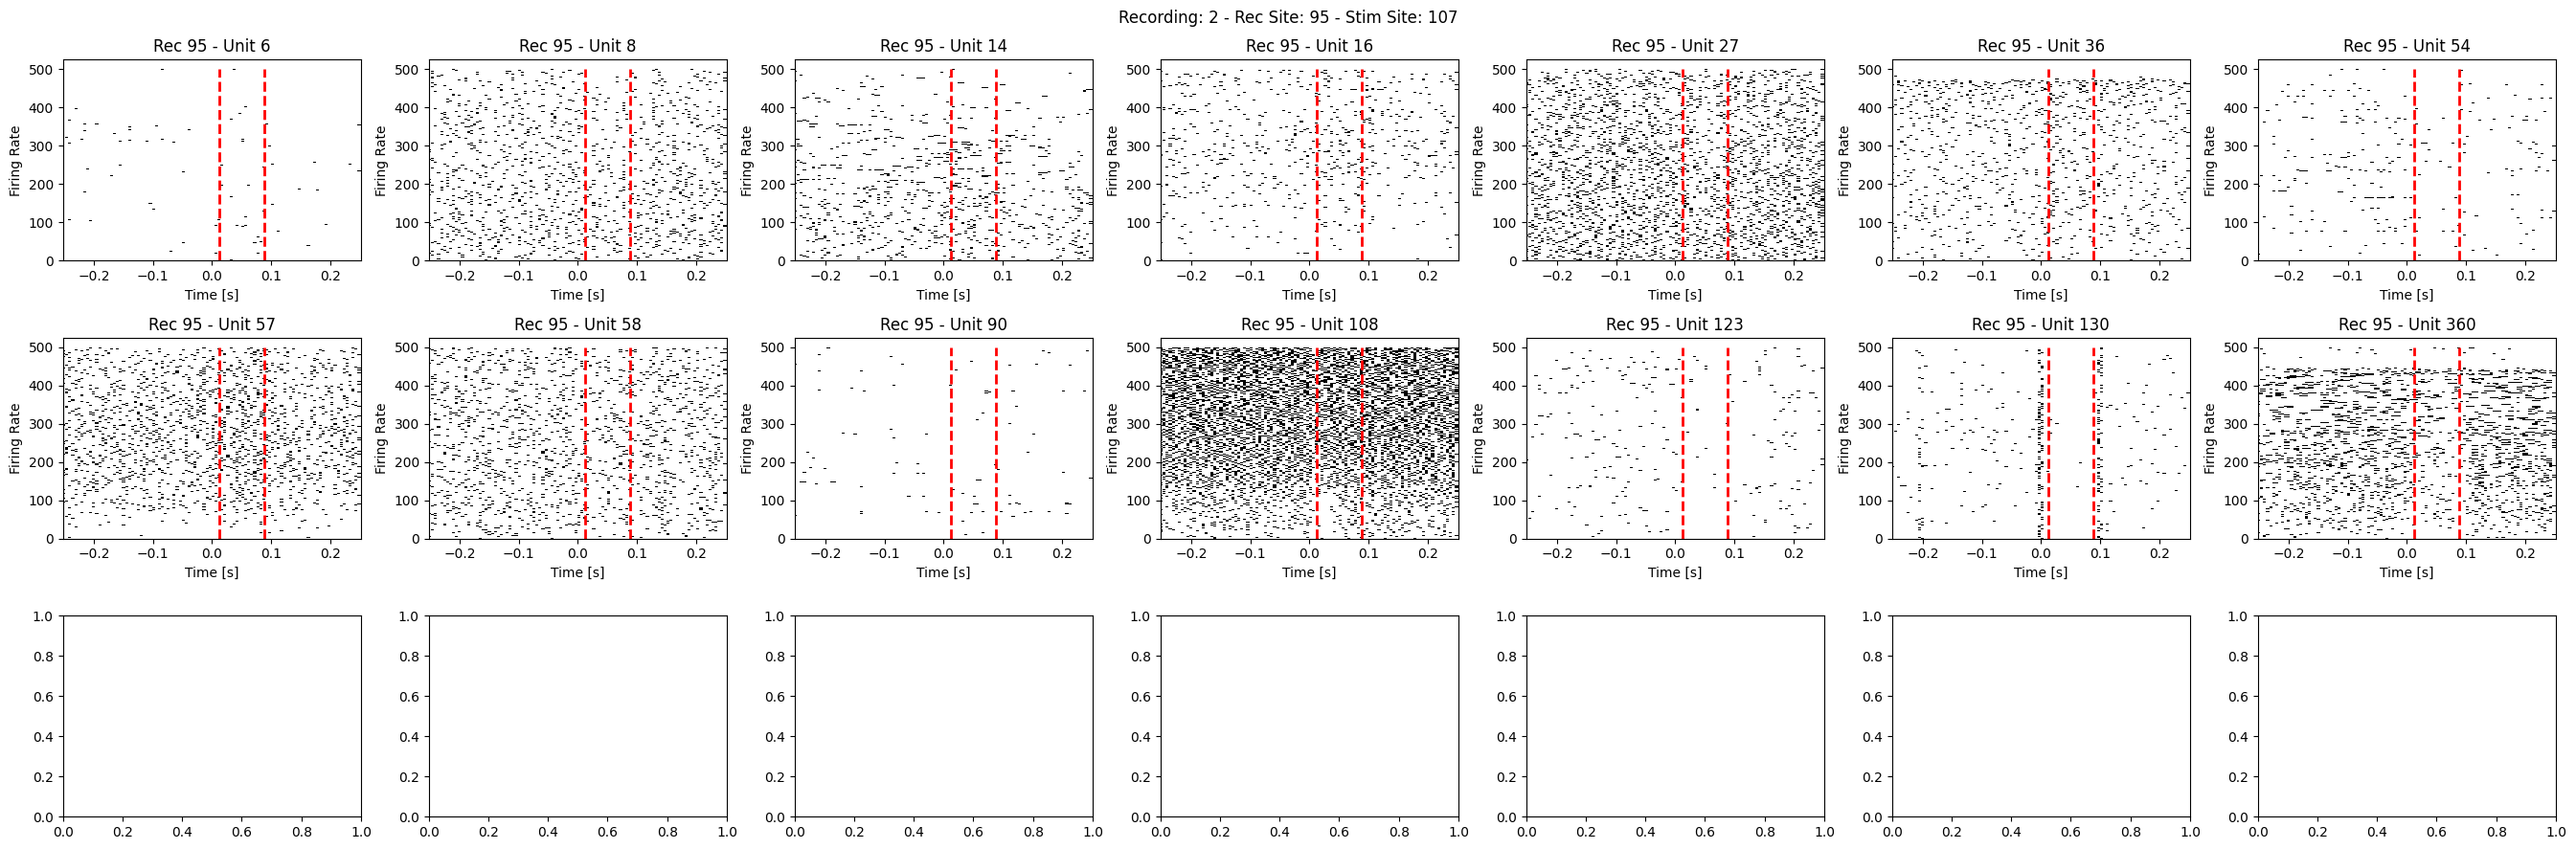

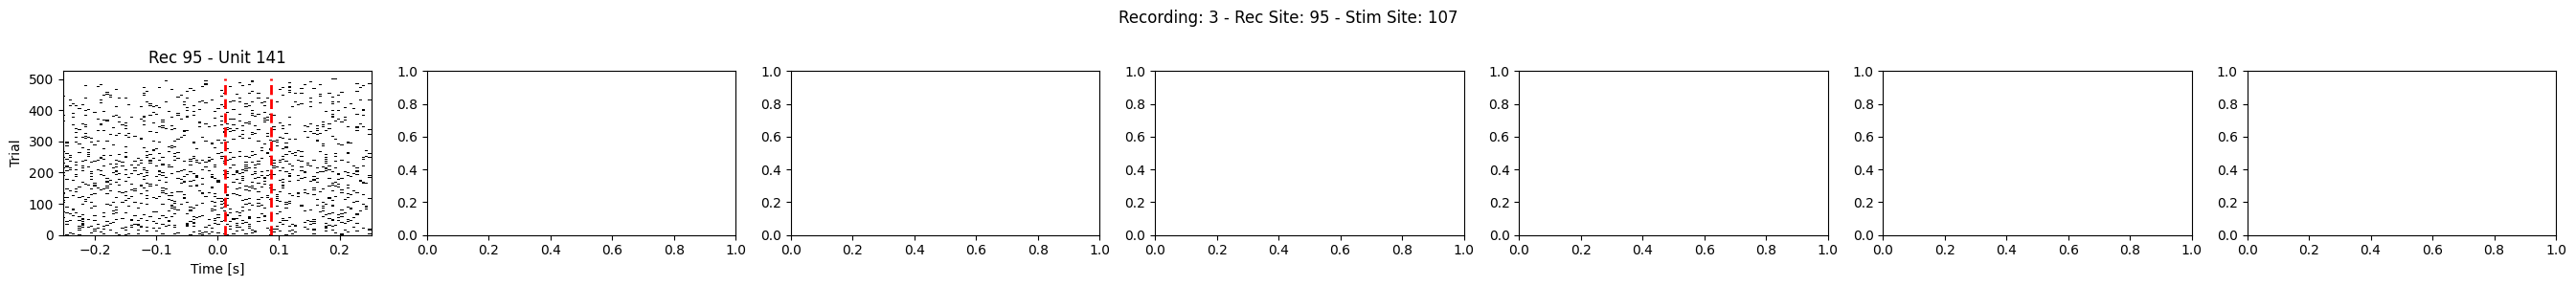

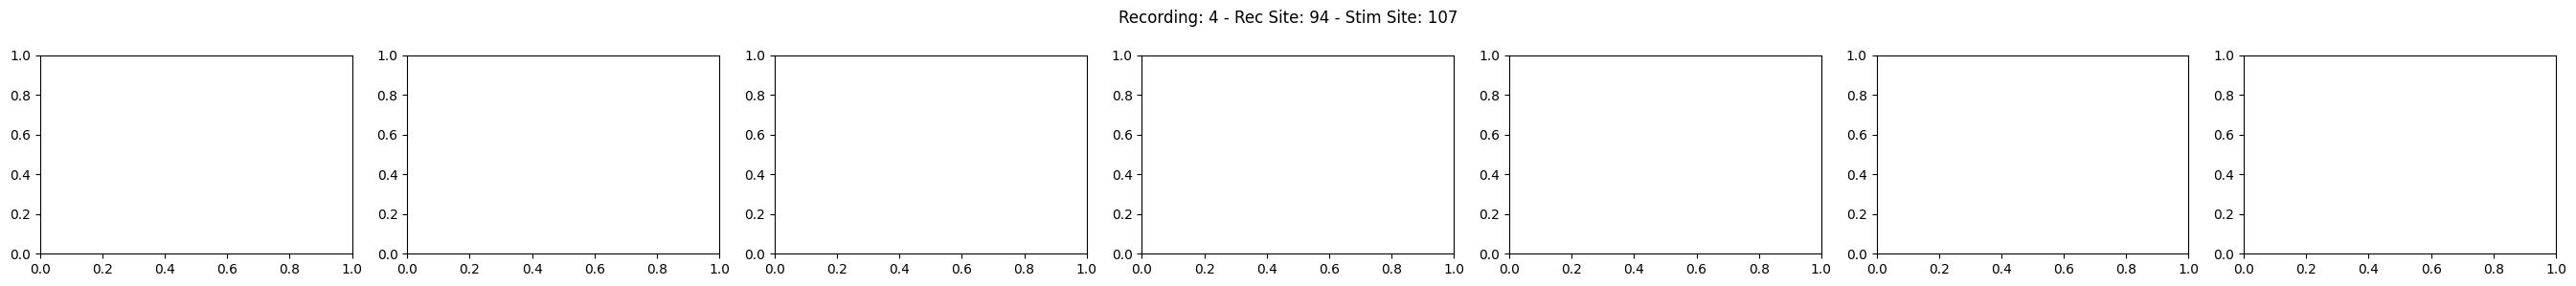

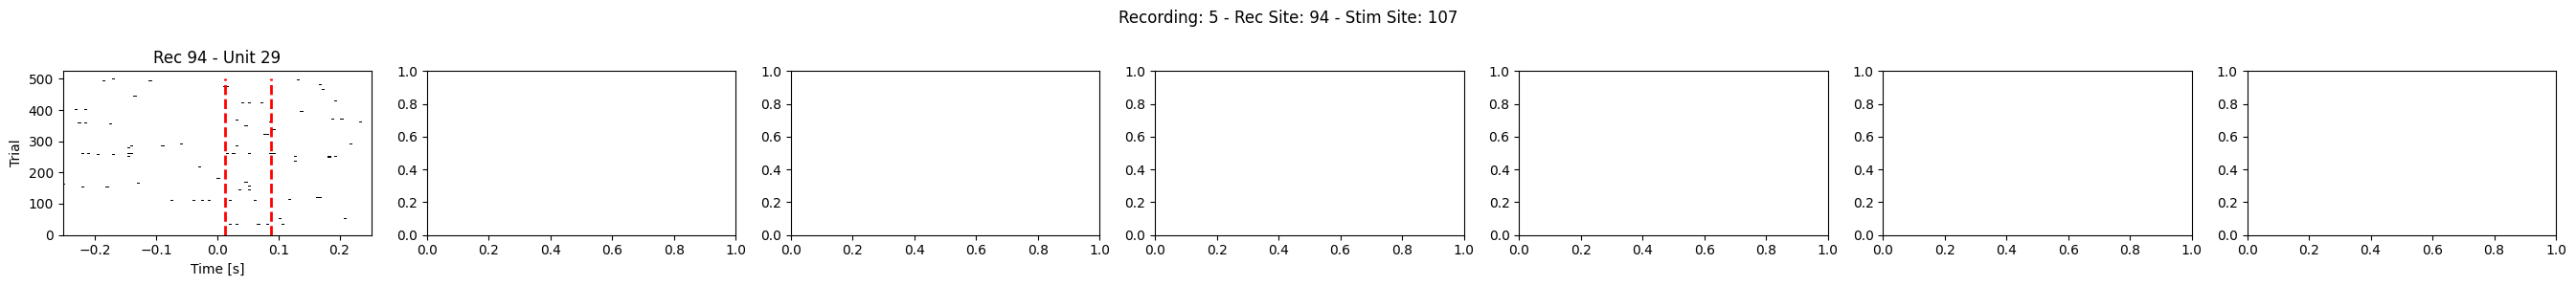

In [19]:
for ioe in range(len(good_opto_entries)):
    ncol = 7
    nrow = (len(resp_unit_idx[ioe])//ncol)+1
    
    fig, ax = plt.subplots(nrow, ncol, figsize=(27, nrow*3))

    for iplot, iunit in enumerate(resp_unit_idx[ioe]):
        irow = iplot//ncol
        icol = iplot % ncol
        # unit2plot = np.where(unit_labels[idate]==[iunit])[0][0]
        
        try:
            ax[irow, icol].pcolor(time_axis, np.arange(len(laser_times[ioe])), spike_align[ioe][:,:,iunit].T, 
                                  cmap='Greys', vmin=0, vmax=1)
            ax[irow, icol].plot([time_axis[int(np.median(laser_start_idx[ioe]))],time_axis[int(np.median(laser_start_idx[ioe]))]], [0,len(laser_times[ioe])], 'r--', linewidth=2)
            ax[irow, icol].plot([time_axis[int(np.median(laser_stop_idx[ioe]))], time_axis[int(np.median(laser_stop_idx[ioe]))]], [0,len(laser_times[ioe])], 'r--', linewidth=2)
            ax[irow, icol].set(xlabel='Time [s]', ylabel='Firing Rate', title=f'Rec {recording_site[ioe]} - Unit {iunit}')

        except:
            ax[icol].pcolor(time_axis, np.arange(len(laser_times[ioe])), spike_align[ioe][:,:,iunit].T, 
                                  cmap='Greys', vmin=0, vmax=1)
            ax[icol].plot([time_axis[int(np.median(laser_start_idx[ioe]))],time_axis[int(np.median(laser_start_idx[ioe]))]], [0,len(laser_times[ioe])], 'r--', linewidth=2)
            ax[icol].plot([time_axis[int(np.median(laser_stop_idx[ioe]))], time_axis[int(np.median(laser_stop_idx[ioe]))]], [0,len(laser_times[ioe])], 'r--', linewidth=2)
            ax[icol].set(xlabel='Time [s]', ylabel='Trial', title=f'Rec {recording_site[ioe]} - Unit {iunit}')
    plt.suptitle(f'Recording: {ioe} - Rec Site: {recording_site[ioe]} - Stim Site: {stim_site[ioe]}')
    fig.tight_layout()
    plt.show()

## Spatial response

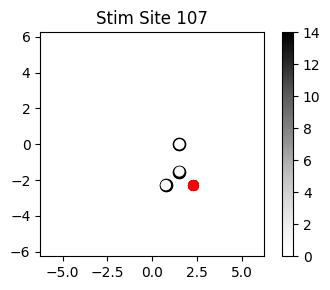

In [20]:
fig, ax = plt.subplots(1,len(unique_stim_sites), figsize=(len(unique_stim_sites)*4,3))
for istim_site, unique_stim in enumerate(unique_stim_sites):
    nstims = np.sum(stim_site==unique_stim)
    resp_units_per_stim_site = np.array(nresp_unit)[stim_site==unique_stim]
    color_grad = aopy.visualization.base.get_color_gradient_RGB(np.max(resp_units_per_stim_site)+1, [0., 0., 0.], [0.75,0.75,0.75])
    unique_stim_idx = np.where(stim_site==unique_stim)[0]
    nresp_units = resp_unit_idx
    
    if len(unique_stim_sites) > 1:
        resp_map = ax[istim_site].scatter(rec_pos[unique_stim_idx,0], rec_pos[unique_stim_idx,1], c='k',s=75, marker='o')
        resp_map = ax[istim_site].scatter(rec_pos[unique_stim_idx,0], rec_pos[unique_stim_idx,1], c=resp_units_per_stim_site,s=40,cmap='Greys')
        # resp_map=[ax[istim_site].scatter(rec_pos[istim_idx,0], rec_pos[istim_idx,1], 14, color=color_grad[resp_units_per_stim_site[ii]]) for ii, istim_idx in enumerate(unique_stim_idx)]
        cb = plt.colorbar(resp_map)
        [ax[istim_site].plot(stim_pos[istim_idx,0], stim_pos[istim_idx,1], 'r.', markersize=14) for istim_idx in unique_stim_idx]
        ax[istim_site].set(xlim=(-6.25, 6.25), ylim=(-6.25, 6.25), title=f"Stim Site {unique_stim}")
        ax[istim_site].set_aspect('equal')
    else:
        resp_map = ax.scatter(rec_pos[unique_stim_idx,0], rec_pos[unique_stim_idx,1], c='k',s=75, marker='o')
        resp_map = ax.scatter(rec_pos[unique_stim_idx,0], rec_pos[unique_stim_idx,1], c=resp_units_per_stim_site,s=40,cmap='Greys')
        # resp_map=[ax[istim_site].scatter(rec_pos[istim_idx,0], rec_pos[istim_idx,1], 14, color=color_grad[resp_units_per_stim_site[ii]]) for ii, istim_idx in enumerate(unique_stim_idx)]
        cb = plt.colorbar(resp_map)
        [ax.plot(stim_pos[istim_idx,0], stim_pos[istim_idx,1], 'r.', markersize=14) for istim_idx in unique_stim_idx]
        ax.set(xlim=(-6.25, 6.25), ylim=(-6.25, 6.25), title=f"Stim Site {unique_stim}")
        ax.set_aspect('equal')
        
fig.tight_layout()
plt.show()

# Plot LFP results

  0%|          | 0/6 [00:00<?, ?it/s]

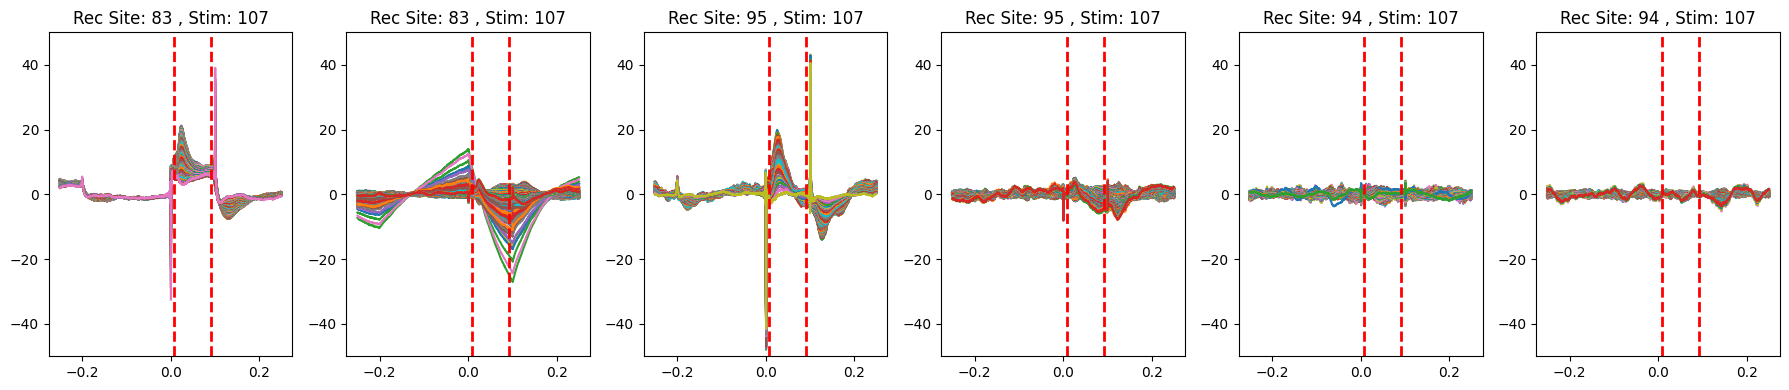

In [21]:
ymaxval = 50
fig, ax = plt.subplots(1, len(recording_site), figsize=(len(recording_site)*3, 4))
for ioe in tqdm(range(len(recording_site))):
    ax[ioe].plot(trial_time_axis_lfp, aligned_lfp_data[ioe])
    ax[ioe].set(title=f"Rec Site: {recording_site[ioe]} , Stim: {stim_site[ioe]}", ylim=(-ymaxval,ymaxval))
    ax[ioe].plot([trial_time_axis_lfp[int(np.median(laser_start_idx_lfp[ioe]))], trial_time_axis_lfp[int(np.median(laser_start_idx_lfp[ioe]))]], [-ymaxval,ymaxval], 'r--', linewidth=2)
    ax[ioe].plot([trial_time_axis_lfp[int(np.median(laser_stop_idx_lfp[ioe]))], trial_time_axis_lfp[int(np.median(laser_stop_idx_lfp[ioe]))]], [-ymaxval,ymaxval], 'r--', linewidth=2)
fig.tight_layout()
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_1865716/1129962965.py:5: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar(temp_map)


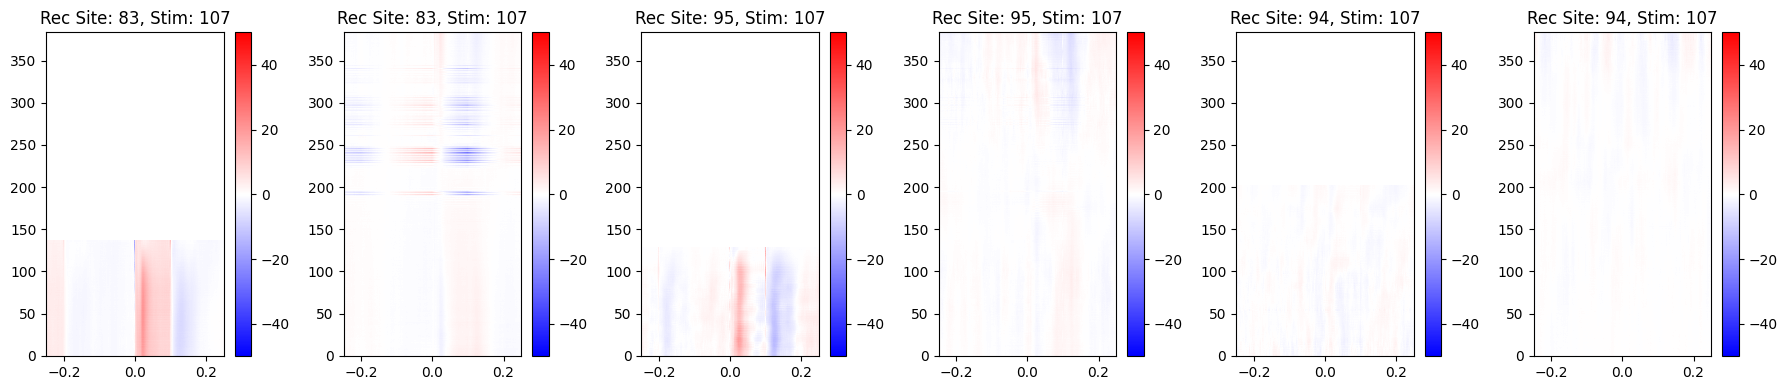

In [22]:
fig, ax = plt.subplots(1, len(recording_site), figsize=(len(recording_site)*3, 4))
for ioe in tqdm(range(len(recording_site))):
    # temp_map = ax[ioe].pcolor(trial_time_axis_lfp, np.arange(nch),aligned_lfp_data[ioe].T, cmap='bwr')
    temp_map = ax[ioe].pcolor(trial_time_axis_lfp, np.arange(nch),aligned_lfp_data[ioe].T, vmin=-ymaxval, vmax=ymaxval, cmap='bwr')
    cb = plt.colorbar(temp_map)
    # temp_map.set_clim(-1000, 1000)
    ax[ioe].set(title=f"Rec Site: {recording_site[ioe]}, Stim: {stim_site[ioe]}")
    
fig.tight_layout()
plt.show()

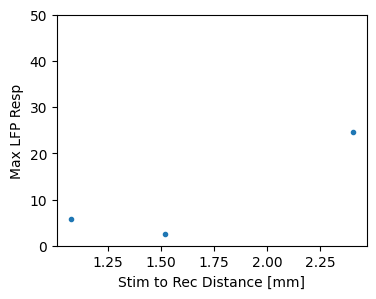

In [23]:
# Plot magnitude of response as a function of distance from stim site (separate for each stim site)
nbadch = 2
max_resp = [np.sort(np.abs(aligned_lfp_data[ioe][int(np.median(laser_start_idx_lfp[ioe])):int(np.median(laser_stop_idx_lfp[ioe])),:]).flatten())[-(nbadch)] for ioe in range(len(recording_site))]

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(rec_stim_dist, max_resp, '.')
ax.set(xlabel="Stim to Rec Distance [mm]", ylabel="Max LFP Resp", ylim=(0, ymaxval))
plt.show()

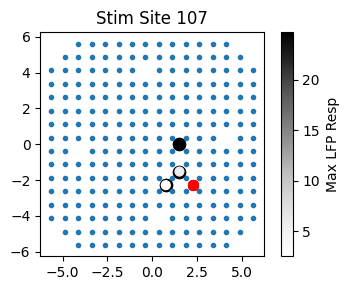

In [24]:
# Plot spatial map of response as a function of distance from stim site (separate for each stim site)
cbmax = 100
fig, ax = plt.subplots(1,len(unique_stim_sites), figsize=(len(unique_stim_sites)*4,3))
for istim_site, unique_stim in enumerate(unique_stim_sites):
    max_resp_per_stim_site = np.array(max_resp)[stim_site==unique_stim]
    max_resp_per_stim_site[max_resp_per_stim_site>cbmax] = cbmax 
    unique_stim_idx = np.where(stim_site==unique_stim)[0]
    nresp_units = resp_unit_idx
    nstims = np.sum(stim_site==unique_stim)
    if len(unique_stim_sites) > 1:
        resp_map = ax[istim_site].scatter(rec_pos[unique_stim_idx,0], rec_pos[unique_stim_idx,1], c='k',s=75, marker='o')
        resp_map = ax[istim_site].scatter(rec_pos[unique_stim_idx,0], rec_pos[unique_stim_idx,1], c=max_resp_per_stim_site,s=40,cmap='Greys')
        cb = plt.colorbar(resp_map, label='Max LFP Resp', )
        [ax[istim_site].plot(stim_pos[istim_idx,0], stim_pos[istim_idx,1], 'r.', markersize=14) for istim_idx in unique_stim_idx]
        ax[istim_site].set(xlim=(-6.25, 6.25), ylim=(-6.25, 6.25), title=f"Stim Site {unique_stim}")
        ax[istim_site].set_aspect('equal')
    else:
        resp_map = ax.scatter(rec_pos[unique_stim_idx,0], rec_pos[unique_stim_idx,1], c='k',s=75, marker='o')
        resp_map = ax.scatter(rec_pos[unique_stim_idx,0], rec_pos[unique_stim_idx,1], c=max_resp_per_stim_site,s=40,cmap='Greys')
        cb = plt.colorbar(resp_map, label='Max LFP Resp', )
        [ax.plot(stim_pos[istim_idx,0], stim_pos[istim_idx,1], 'r.', markersize=14) for istim_idx in unique_stim_idx]
        ax.set(xlim=(-6.25, 6.25), ylim=(-6.25, 6.25), title=f"Stim Site {unique_stim}")
        ax.set_aspect('equal')
        
    # Plot ecog map
    plt.plot(ecog_dec_acc[subject]['ecog_dec_acc_elec_pos'][:,0], ecog_dec_acc[subject]['ecog_dec_acc_elec_pos'][:,1], '.')
fig.tight_layout()
plt.show()

# Quantify LFP response

## Basic spectral analysis

0.1 1.5 2


  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_1865716/3232736499.py:15: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb1 = plt.colorbar(ax1)
/tmp/ipykernel_1865716/3232736499.py:16: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb2 = plt.colorbar(ax2)


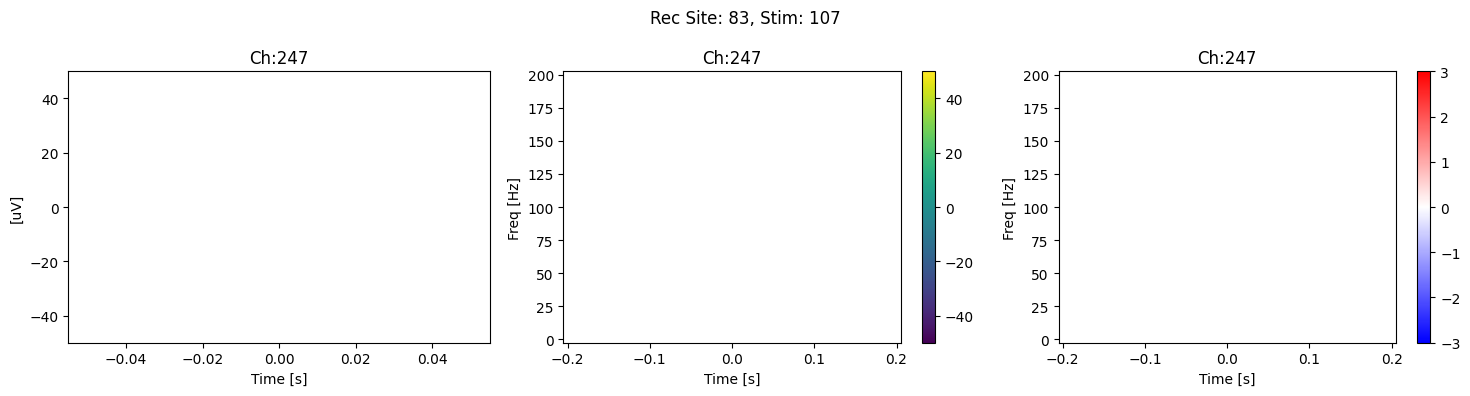

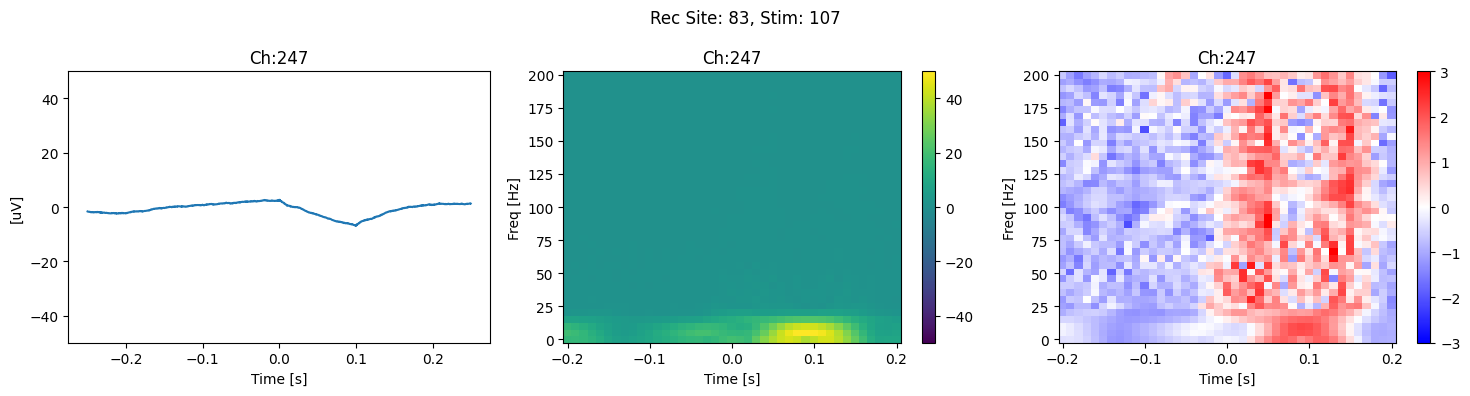

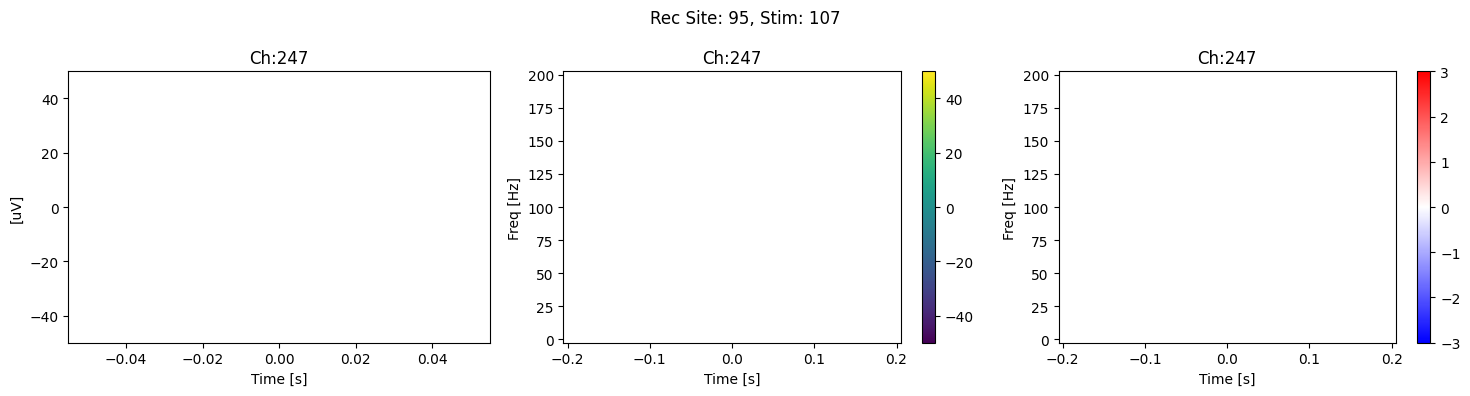

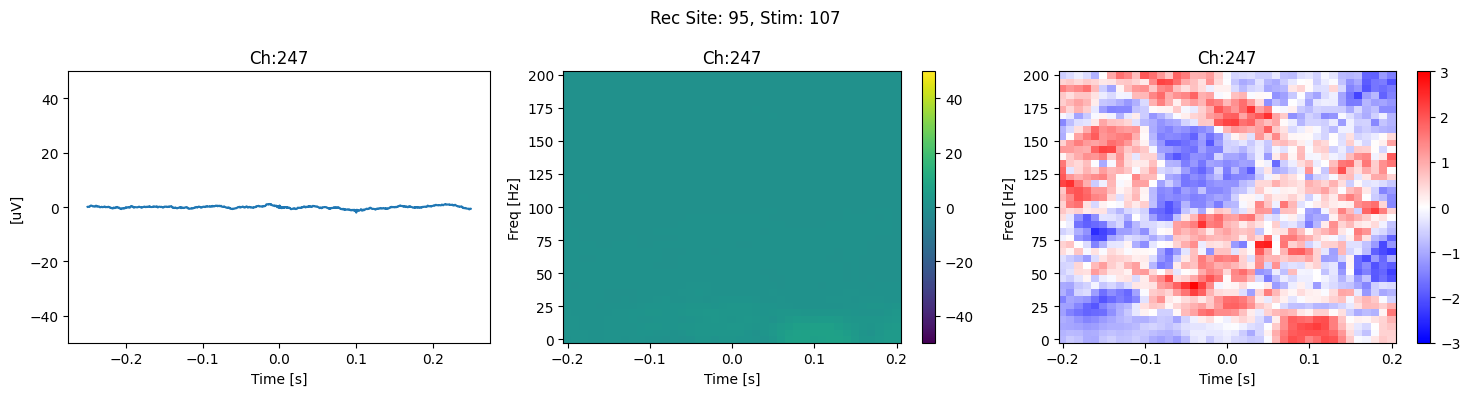

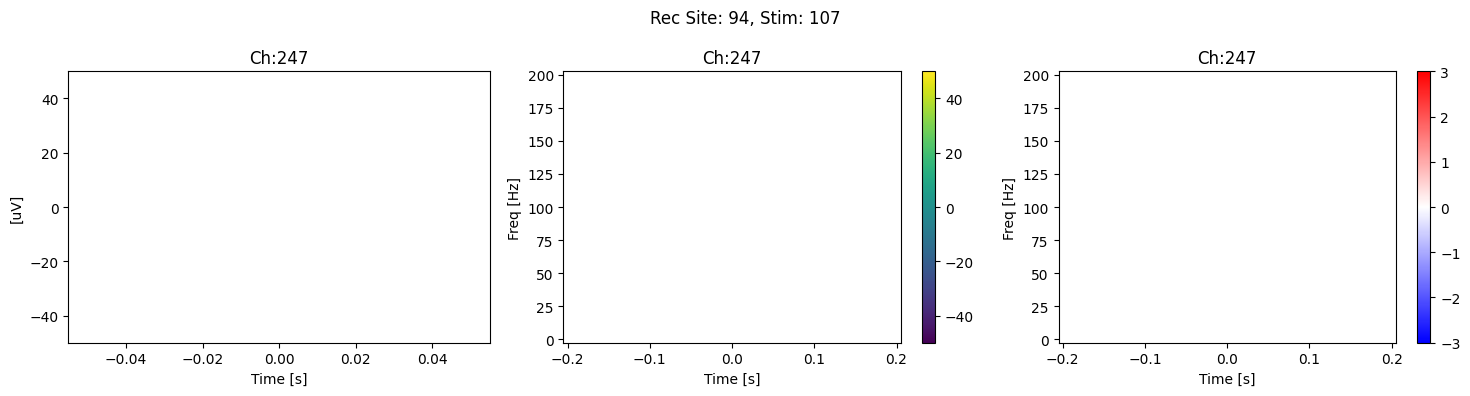

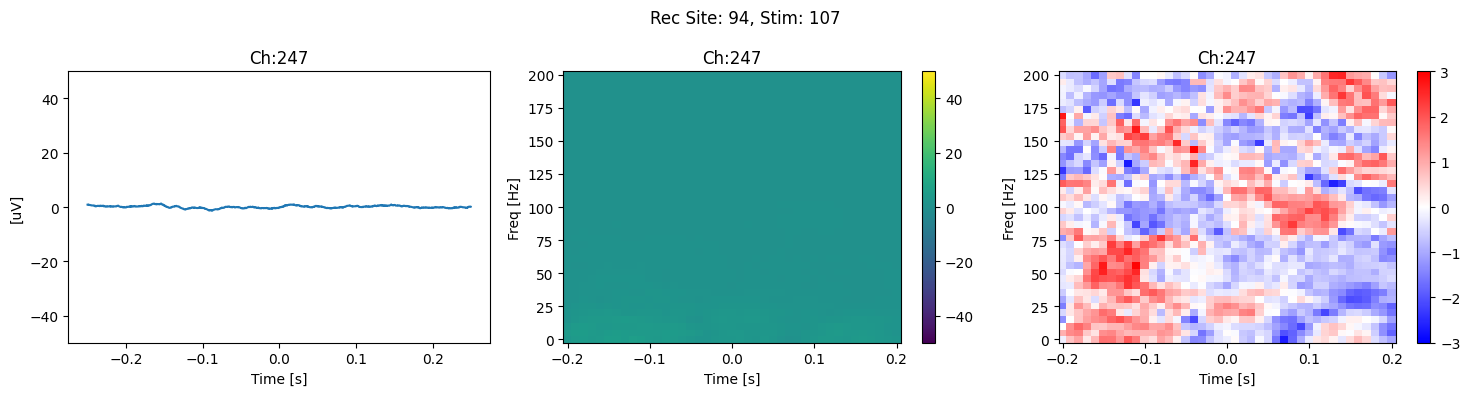

In [25]:
lim_max = 50
n = 0.1
w = 15
step = 0.005
n, p, k = aopy.precondition.base.convert_taper_parameters(n,w)
print(n, p, k)
ich = 247
for ioe in tqdm(range(len(recording_site))):
    f, t, spec = aopy.analysis.base.calc_mt_tfr(aligned_lfp_data[ioe][:,ich][:,None], n, p, k, samplerate_lfp, fk=200)
    
    fig, ax = plt.subplots(1,3,figsize=(15,4))
    ax[0].plot(trial_time_axis_lfp, aligned_lfp_data[ioe][:,ich])
    ax1 = ax[1].pcolor(t-tbefore, f, spec[:,:,0], vmin=-lim_max, vmax=lim_max)
    ax2 = ax[2].pcolor(t-tbefore, f, (spec[:,:,0]-np.mean(spec[:,:,0], axis=1)[:,None])/np.std(spec[:,:,0],axis=1)[:,None], cmap='bwr', vmin=-3, vmax=3)
    cb1 = plt.colorbar(ax1)
    cb2 = plt.colorbar(ax2)
    
    ax[0].set(xlabel='Time [s]', ylabel='[uV]', title=f"Ch:{ich}", ylim=(-lim_max, lim_max))
    ax[1].set(xlabel='Time [s]', ylabel='Freq [Hz]', title=f"Ch:{ich}")
    ax[2].set(xlabel='Time [s]', ylabel='Freq [Hz]', title=f"Ch:{ich}")
    
    plt.suptitle(f"Rec Site: {recording_site[ioe]}, Stim: {stim_site[ioe]}")
    fig.tight_layout()
    plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

NameError: name 'lfp_ch_cutoff' is not defined

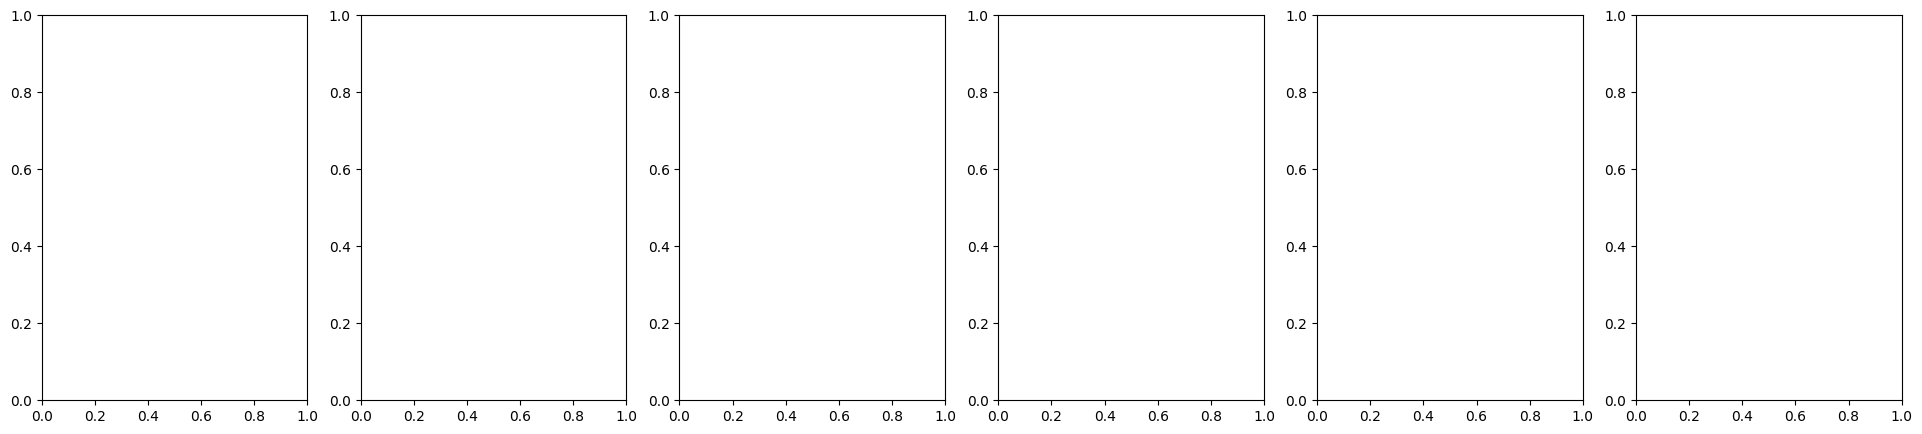

In [26]:
# Plot responses colored as a function of depth
fig, ax = plt.subplots(1,len(recording_site),figsize=(4*len(recording_site), 5))
for ioe in tqdm(range(len(recording_site))):
    color_grad = aopy.visualization.base.get_color_gradient_RGB(lfp_ch_cutoff[ioe], [.63,.13,.94], [0,1,0]) # blue is bottom channels, 
    for ich in range(lfp_ch_cutoff[ioe]):
        ax[ioe].plot(trial_time_axis_lfp*1000, aligned_lfp_data[ioe][:,:lfp_ch_cutoff[ioe]][:,ich],linewidth=.1, color=color_grad[ich])
    
    
    ax[ioe].set(xlim=(-10,50), ylim=(-25, 25), xlabel='Time [ms]')
    

In [ ]:
fig, ax = plt.subplots(1, len(recording_site), figsize=(len(recording_site)*3, 4))
for ioe in tqdm(range(len(recording_site))):
    # temp_map = ax[ioe].pcolor(trial_time_axis_lfp, np.arange(nch),aligned_lfp_data[ioe].T, cmap='bwr')
    temp_map = ax[ioe].pcolor(1000*trial_time_axis_lfp, np.arange(nch),aligned_lfp_data[ioe].T, vmin=-ymaxval, vmax=ymaxval, cmap='bwr')
    cb = plt.colorbar(temp_map)
    ax[ioe].plot([1000*trial_time_axis_lfp[0], 1000*trial_time_axis_lfp[-1]], [bad_ch_cutoff[ioe], bad_ch_cutoff[ioe]], 'k--')
    # temp_map.set_clim(-1000, 1000)
    # ax[ioe].plot((-10, 50), [lfp_ch_cutoff[ioe], lfp_ch_cutoff[ioe]], color='black')
    ax[ioe].set(title=f"Rec Site: {recording_site[ioe]}, Stim: {stim_site[ioe]}", xlabel='Time [ms]', xlim=(-10,50))
    
    
fig.tight_layout()
plt.show()

In [ ]:
aligned_lfp_data[1].shape
plt.plot(trial_time_axis_lfp, aligned_lfp_data[1][:,242])
plt.title('Trial Averaged')
plt.show()

In [ ]:
aligned_lfp_data_trial[1].shape
plt.pcolor(trial_time_axis_lfp, np.arange(500), aligned_lfp_data_trial[1][:,:,242].T)
plt.title('Single Trial')
plt.xlabel('Time [s]')
plt.ylabel('Trial')
plt.show()

In [ ]:
# Plot non-trial aligned section of the time series
oe = opto_entries [1]
# Load data
exp_data, exp_metadata = aopy.data.load_preproc_exp_data(data_path_preproc, subject, oe.id, oe.date.date())
filename_opto = aopy.data.get_preprocessed_filename(subject, oe.id, oe.date.date(), 'lfp')
lfp_data = aopy.data.load_hdf_group(os.path.join(data_path_preproc, subject), filename_opto, 'lfp')
clean_lfp_data, bad_ch = aopy.data.base.pkl_read(f'lfp_destriped_{oe.id}', clean_lfp_path)
laser_info = aopy.preproc.bmi3d.get_laser_trial_times(data_path_preproc, subject, oe.id, oe.date.date())

In [ ]:
# print(np.round(laser_info[0]*lfp_metadata['sample_rate']))
print(np.where(lfp_data['sync_timestamp'] >= laser_info[0][1])[0][0])
laser_on = np.array([np.where(lfp_data['sync_timestamp'] >= laser_info[0][0])[0][0], np.where(lfp_data['sync_timestamp'] >= laser_info[0][1])[0][0], np.where(lfp_data['sync_timestamp'] >= laser_info[0][2])[0][0]])
print(laser_on)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
plt.plot(clean_lfp_data[244,14000:19000])
plt.plot([laser_on-14000, laser_on-14000], [-150,150], 'r')
plt.title('Ch 245')

## Imaginary Coherence on each individual recording

In [ ]:
n = 0.05
w = 35
step = 0.01
n, p, k = aopy.precondition.base.convert_taper_parameters(n,w)
print(n, p, k)
f, t, coh = aopy.analysis.base.calc_mt_tfcoh(np.swapaxes(aligned_lfp_data_trial[ioe], 1,2), (100,0), n,p,k, lfp_metadata['sample_rate'], step, fk=200, imaginary=True)
coh_mats = []
for ioe in range(len(opto_entries)):
    coh_mat = np.zeros((t.shape[0], f.shape[0], nch))*np.nan
    for ich in tqdm(range(bad_ch_cutoff[ioe])):
        f, t, coh_temp = aopy.analysis.base.calc_mt_tfcoh(np.swapaxes(aligned_lfp_data_trial[ioe], 1,2), (bad_ch_cutoff[ioe],ich), n,p,k, lfp_metadata['sample_rate'], step, fk=200, imaginary=True)
        coh_mat[:,:,ich] = coh_temp.T
            
    coh_mats.append(coh_mat)
    t=t-tbefore
print(aligned_lfp_data_trial[ioe].shape, np.swapaxes(aligned_lfp_data_trial[ioe], 1,2).shape,  lfp_metadata['sample_rate'])

In [ ]:
fig, ax = plt.subplots(1,len(opto_entries), figsize=(len(opto_entries)*4, 4))
tidx = 40
for ioe in range(len(opto_entries)):
    im_coh_map = ax[ioe].pcolor(f, np.arange(nch), coh_mats[ioe][tidx,:,:].T, vmin=0, vmax=0.4)
    ax[ioe].set(ylabel='Ch', xlabel='Frequency', title=f'Im Coh to Top Ch at t={np.round(t[tidx],4)}')
    cb = plt.colorbar(im_coh_map)
fig.tight_layout()
plt.show()
    # color_grad = aopy.visualization.base.get_color_gradient_RGB(lfp_ch_cutoff[ioe], [.63,.13,.94], [0,1,0]) # green is bottom channels, 
    # for ich in range(lfp_ch_cutoff[ioe]):
    #     ax[ioe].plot(trial_time_axis_lfp*1000, coh_mats[ioe][:,:lfp_ch_cutoff[ioe]][tidx,:,ich],linewidth=.1, color=color_grad[ich])

In [ ]:
fig, ax = plt.subplots(1,len(opto_entries), figsize=(len(opto_entries)*4, 5))
for ioe in range(len(opto_entries)):
    color_grad = aopy.visualization.base.get_color_gradient_RGB(lfp_ch_cutoff[ioe], [.63,.13,.94], [0,1,0]) # blue is bottom channels, 
    ax[ioe].set(xlabel='Time [s]', ylabel='Im Coh', ylim=(0,0.4), title=f"Rec Site: {recording_site[ioe]}, Stim: {stim_site[ioe]}")
    for ich in range(lfp_ch_cutoff[ioe]):
        ax[ioe].plot(t, np.mean(coh_mats[ioe][:,beta_idx,ich], axis=1), color=color_grad[ich])
    
plt.suptitle(f'Beta (12-30Hz)')
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1,len(opto_entries), figsize=(len(opto_entries)*4, 5))
for ioe in range(len(opto_entries)):
    color_grad = aopy.visualization.base.get_color_gradient_RGB(lfp_ch_cutoff[ioe], [.63,.13,.94], [0,1,0]) # blue is bottom channels, 
    ax[ioe].set(xlabel='Time [s]', ylabel='Im Coh', ylim=(0,0.4), title=f"Rec Site: {recording_site[ioe]}, Stim: {stim_site[ioe]}")
    for ich in range(lfp_ch_cutoff[ioe]):
        ax[ioe].plot(t, np.mean(coh_mats[ioe][:,hgamma_idx,ich], axis=1), color=color_grad[ich])
    
plt.suptitle(f'High Gamma (80-150Hz)')
fig.tight_layout()
plt.show()

## Imaginary Coherance on ch-concatenated data


In [ ]:
# Concatenate data
unique_rec_sites = np.unique(recording_site)
print(unique_rec_sites)
site_coh_mats = []
for irec, site in enumerate(unique_rec_sites):
    site_oe_idx = np.where(recording_site==site)[0]
    print(site_oe_idx)
    for isite in range(len(site_oe_idx)):
        if isite == 0:
            temp_data = aligned_lfp_data_trial[site_oe_idx[isite]][:,:500,:]
        else:
            temp_data = np.concatenate((aligned_lfp_data_trial[site_oe_idx[isite]][:,:500,:],temp_data), axis=2)
            
    temp_ch_cutoff = np.sum(np.array(bad_ch_cutoff)[site_oe_idx])
    coh_mat = np.zeros((t.shape[0], f.shape[0], temp_data.shape[2]))*np.nan
    for ich in tqdm(range(temp_ch_cutoff)):
        f, t, coh_temp = aopy.analysis.base.calc_mt_tfcoh(np.swapaxes(temp_data, 1,2), (temp_ch_cutoff,ich), n,p,k, lfp_metadata['sample_rate'], step, fk=200, imaginary=True)
        coh_mat[:,:,ich] = coh_temp.T
            
    site_coh_mats.append(coh_mat)
    t=t-tbefore
    print(temp_data.shape, temp_ch_cutoff)

In [ ]:
fig, ax = plt.subplots(1,len(site_coh_mats), figsize=(len(site_coh_mats)*4, 4))
tidx = 25
for irec, site in enumerate(unique_rec_sites):
    im_coh_map = ax[irec].pcolor(f, np.arange(site_coh_mats[irec].shape[2]), site_coh_mats[irec][tidx,:,:].T, vmin=0, vmax=0.3)
    ax[irec].set(ylabel='Ch', xlabel='Frequency', title=f'Im Coh to Top Ch at t={np.round(t[tidx],4)}')
    cb = plt.colorbar(im_coh_map)
fig.tight_layout()
plt.show()
    # color_grad = aopy.visualization.base.get_color_gradient_RGB(lfp_ch_cutoff[ioe], [.63,.13,.94], [0,1,0]) # green is bottom channels, 
    # for ich in range(lfp_ch_cutoff[ioe]):
    #     ax[ioe].plot(trial_time_axis_lfp*1000, coh_mats[ioe][:,:lfp_ch_cutoff[ioe]][tidx,:,ich],linewidth=.1, color=color_grad[ich])